In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from dateutil.parser import parse
import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import r2_score

sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#### Load Prince St data

In [9]:
prince_daily_unclean = pd.read_csv('prince_daily_unclean.csv', parse_dates=['Date']) 

#### Load Weather Data

In [11]:
df_weather = pd.read_csv('../Data/1488573.csv')
print(df_weather.shape)

(1733, 44)


In [12]:
# examine the head of weather data
pd.options.display.max_columns = 50
df_weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PGTM,PGTM_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TSUN,TSUN_ATTRIBUTES,WDF2,WDF2_ATTRIBUTES,WDF5,WDF5_ATTRIBUTES,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT02,WT02_ATTRIBUTES,WT03,WT03_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT06,WT06_ATTRIBUTES,WT08,WT08_ATTRIBUTES
0,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,2014-01-01,5.59,",,W",NaN,NaN,0.00,",,W,2400",0.0,",,W,",0.0,",,W,",NaN,NaN,33,",,W",24,",,W",NaN,NaN,280.0,",,W",300.0,",,W",14.1,",,W",23.0,",,W",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,2014-01-02,12.30,",,W",NaN,NaN,0.33,",,W,2400",3.1,",,W,",0.0,",,W,",NaN,NaN,33,",,W",18,",,W",NaN,NaN,50.0,",,W",50.0,",,W",21.0,",,W",28.0,",,W",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,2014-01-03,10.51,",,W",NaN,NaN,0.29,",,W,2400",3.3,",,W,",5.9,",,W,",NaN,NaN,18,",,W",9,",,W",NaN,NaN,360.0,",,W",310.0,",,W",21.0,",,W",29.1,",,W",1.0,",,W",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,2014-01-04,4.92,",,W",NaN,NaN,0.00,",,W,2400",0.0,",,W,",5.9,",,W,",NaN,NaN,29,",,W",8,",,W",NaN,NaN,260.0,",,W",240.0,",,W",8.9,",,W",19.9,",,W",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,2014-01-05,3.80,",,W",NaN,NaN,0.14,",,W,2400",0.0,"T,,W,",3.9,",,W,",NaN,NaN,40,",,W",27,",,W",NaN,NaN,70.0,",,W",240.0,",,W",6.9,",,W",17.0,",,W",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Remove all spaces in column names
df_weather.columns = df_weather.columns.str.replace(' ', '')

In [14]:
Weather_CP = pd.DataFrame(df_weather.groupby(['DATE', 'PRCP', 'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'TMAX', "TMIN"])['LATITUDE','LONGITUDE'].mean())

In [15]:
Weather_CP.head()

,,,,,,,LATITUDE,LONGITUDE
DATE,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,TMAX,TMIN,,
2014-01-01,0.00,",,W,2400",0.0,",,W,",33,24,40.77898,-73.96925
2014-01-02,0.33,",,W,2400",3.1,",,W,",33,18,40.77898,-73.96925
2014-01-03,0.29,",,W,2400",3.3,",,W,",18,9,40.77898,-73.96925
2014-01-04,0.00,",,W,2400",0.0,",,W,",29,8,40.77898,-73.96925
2014-01-05,0.14,",,W,2400",0.0,"T,,W,",40,27,40.77898,-73.96925


In [16]:
Weather_CP.reset_index(inplace=True)

In [17]:
Weather_CP.head()

,DATE,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,TMAX,TMIN,LATITUDE,LONGITUDE
0,2014-01-01,0.00,",,W,2400",0.0,",,W,",33,24,40.77898,-73.96925
1,2014-01-02,0.33,",,W,2400",3.1,",,W,",33,18,40.77898,-73.96925
2,2014-01-03,0.29,",,W,2400",3.3,",,W,",18,9,40.77898,-73.96925
3,2014-01-04,0.00,",,W,2400",0.0,",,W,",29,8,40.77898,-73.96925
4,2014-01-05,0.14,",,W,2400",0.0,"T,,W,",40,27,40.77898,-73.96925


In [18]:
Weather_CP.rename({"DATE" : "Date"}, axis='columns', inplace=True)

In [19]:
Weather_CP['Date'] = pd.to_datetime(Weather_CP['Date'])

In [21]:
Weather_CP.drop(columns=['LATITUDE', 'LONGITUDE'], inplace=True)

In [23]:
Weather_CP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 7 columns):
Date               1733 non-null datetime64[ns]
PRCP               1733 non-null float64
PRCP_ATTRIBUTES    1733 non-null object
SNOW               1733 non-null float64
SNOW_ATTRIBUTES    1733 non-null object
TMAX               1733 non-null int64
TMIN               1733 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 94.9+ KB


In [22]:
df = pd.merge(left=prince_daily_unclean, right=Weather_CP, how='left')

In [35]:
weather_features = ['PRCP', 'SNOW', 'TMAX', 'TMIN', 'Hourly_Entries']

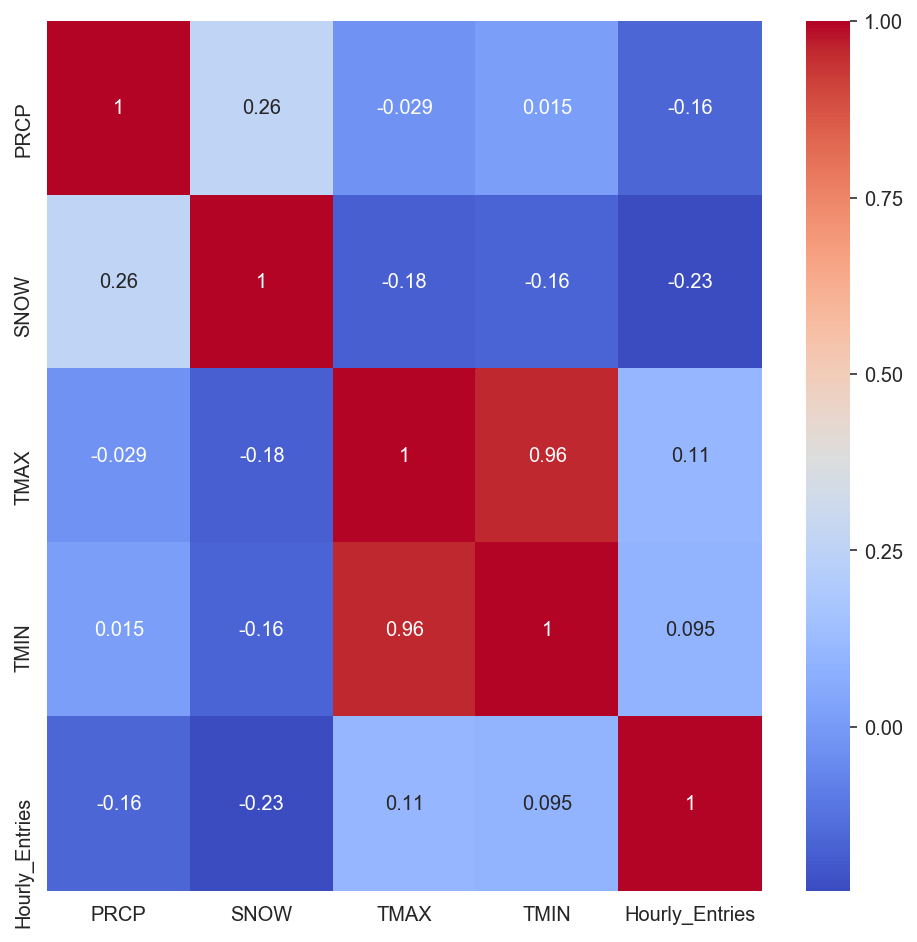

In [49]:
#Create a heatmap on the Regressoin Subset
plt.figure(figsize=(8,8))
sns.heatmap(df[weather_features].corr(), cmap='coolwarm', annot=True);

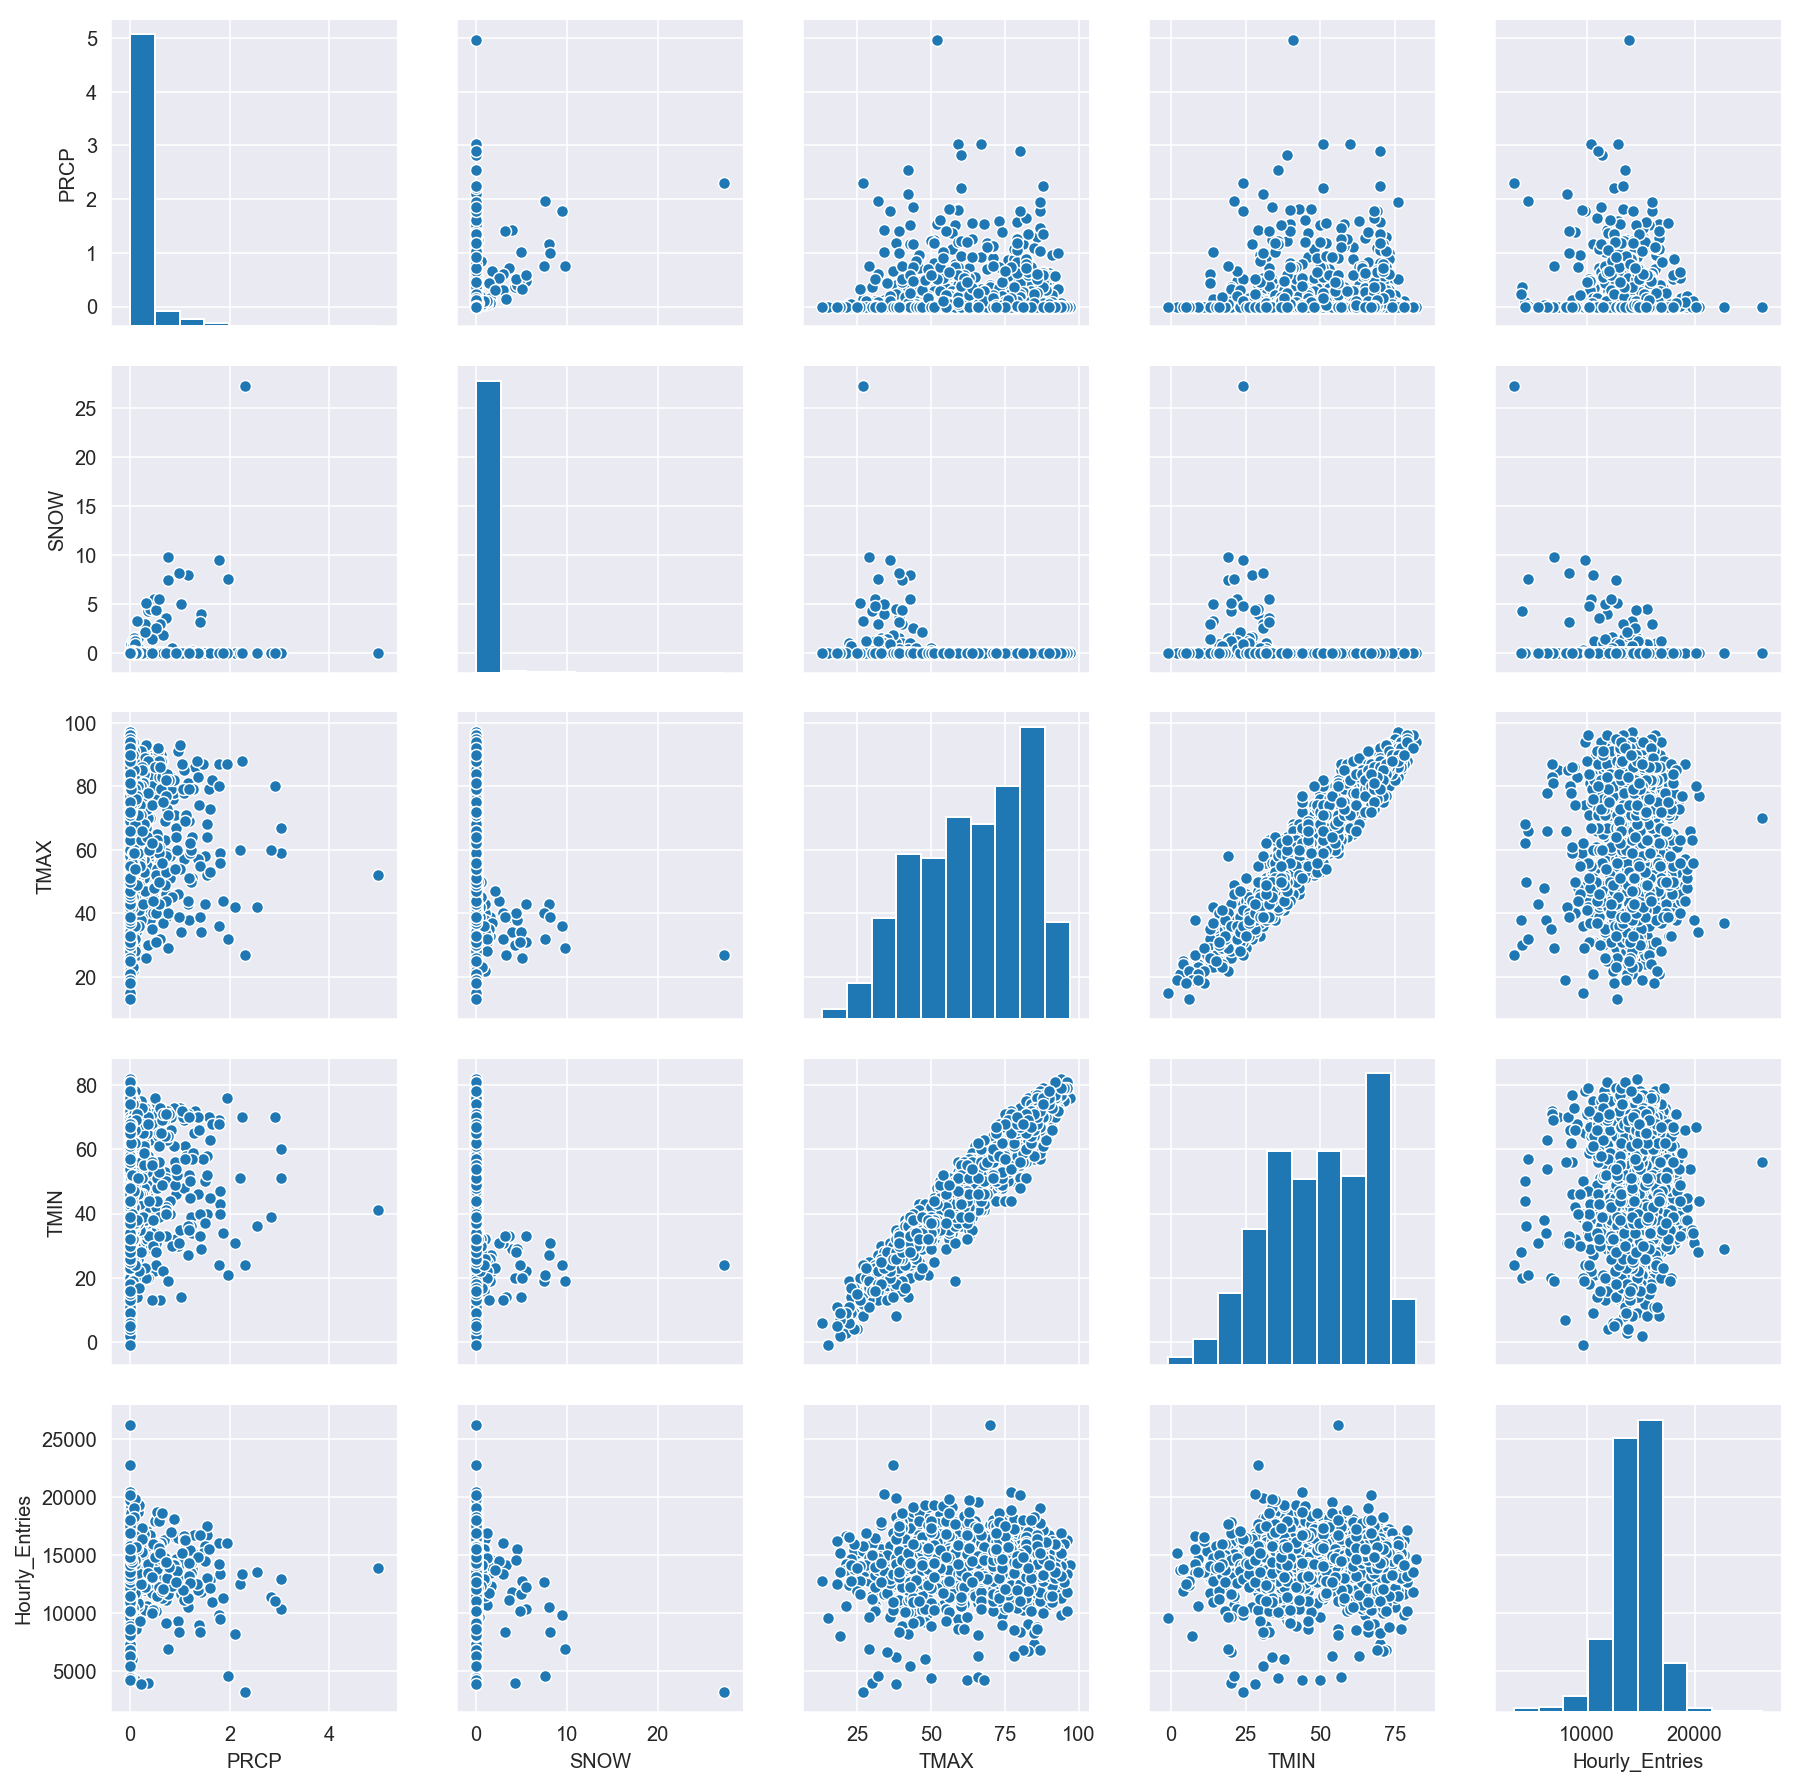

In [37]:
sns.pairplot(df[weather_features]);

In [93]:
# One hot if a day had precpitation or snow
df['has_PRCP'] = np.where(df.PRCP > 0, 1, 0)
df['has_SNOW'] = np.where(df.SNOW > 0, 1, 0)

# One hot for days with heavy amounts of rain or snow
df['has_heavy_PRCP'] = np.where(df.PRCP > 1.5, 1, 0)
df['has_heavy_SNOW'] = np.where(df.SNOW > 4, 1, 0)


### Precipiation affects number of Entries
As Prince St station is located in the popular shopping neighborhood of Soho many of the trip to and from are discretionary and on days where there is precipitation ridership numbers during the workweek are lower while those in the weekend seem not to be affected as much.  Perhaps this is showing the afterwork or more spur of the moment trips where some would would either pop down to Soho or walk ovver from a nearby area are skipped when there is precipitation while trips which may have been planned to go over the weekend are not as affected.

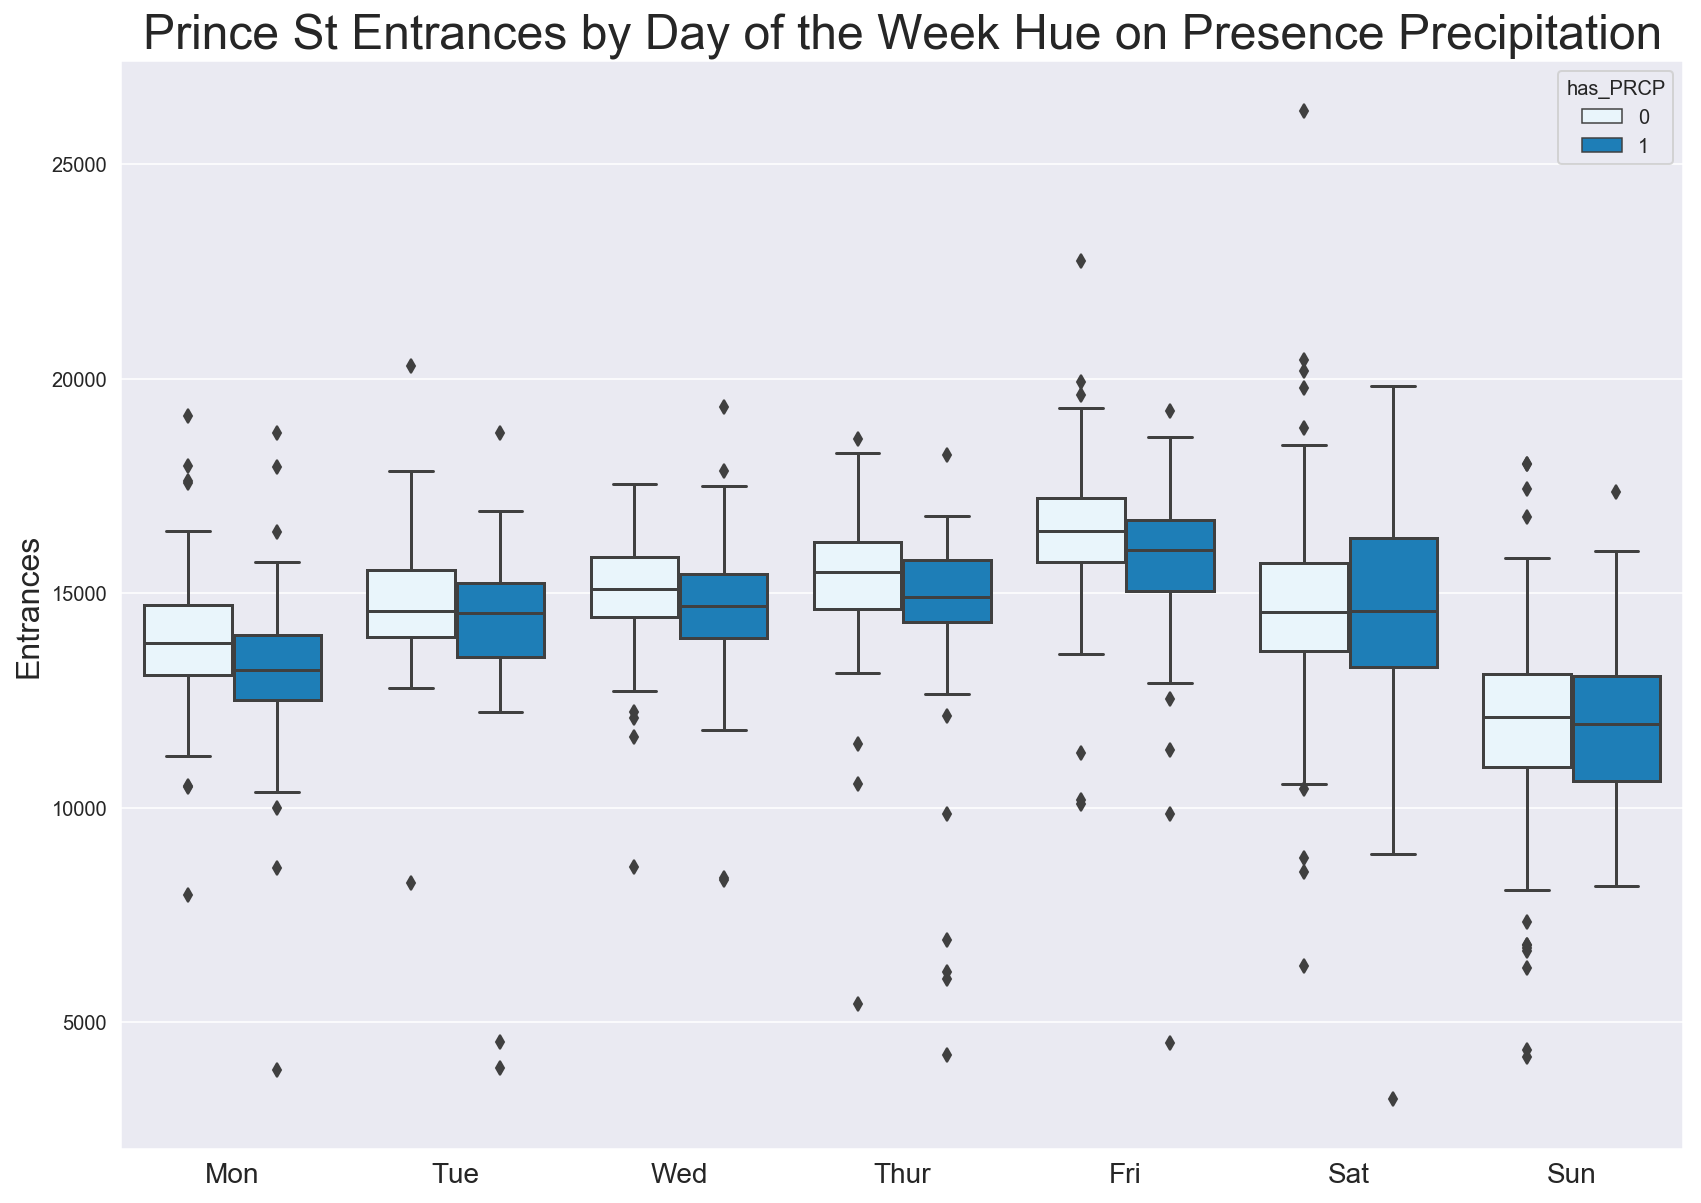

In [71]:
plt.figure(figsize=(14,10))
sns.boxplot(data=df, x='weekday', y='Hourly_Entries', hue='has_PRCP', color='#0485d1');
plt.title('Prince St Entrances by Day of the Week Hue on Presence Precipitation', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('', fontsize=16);
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], fontsize=14);

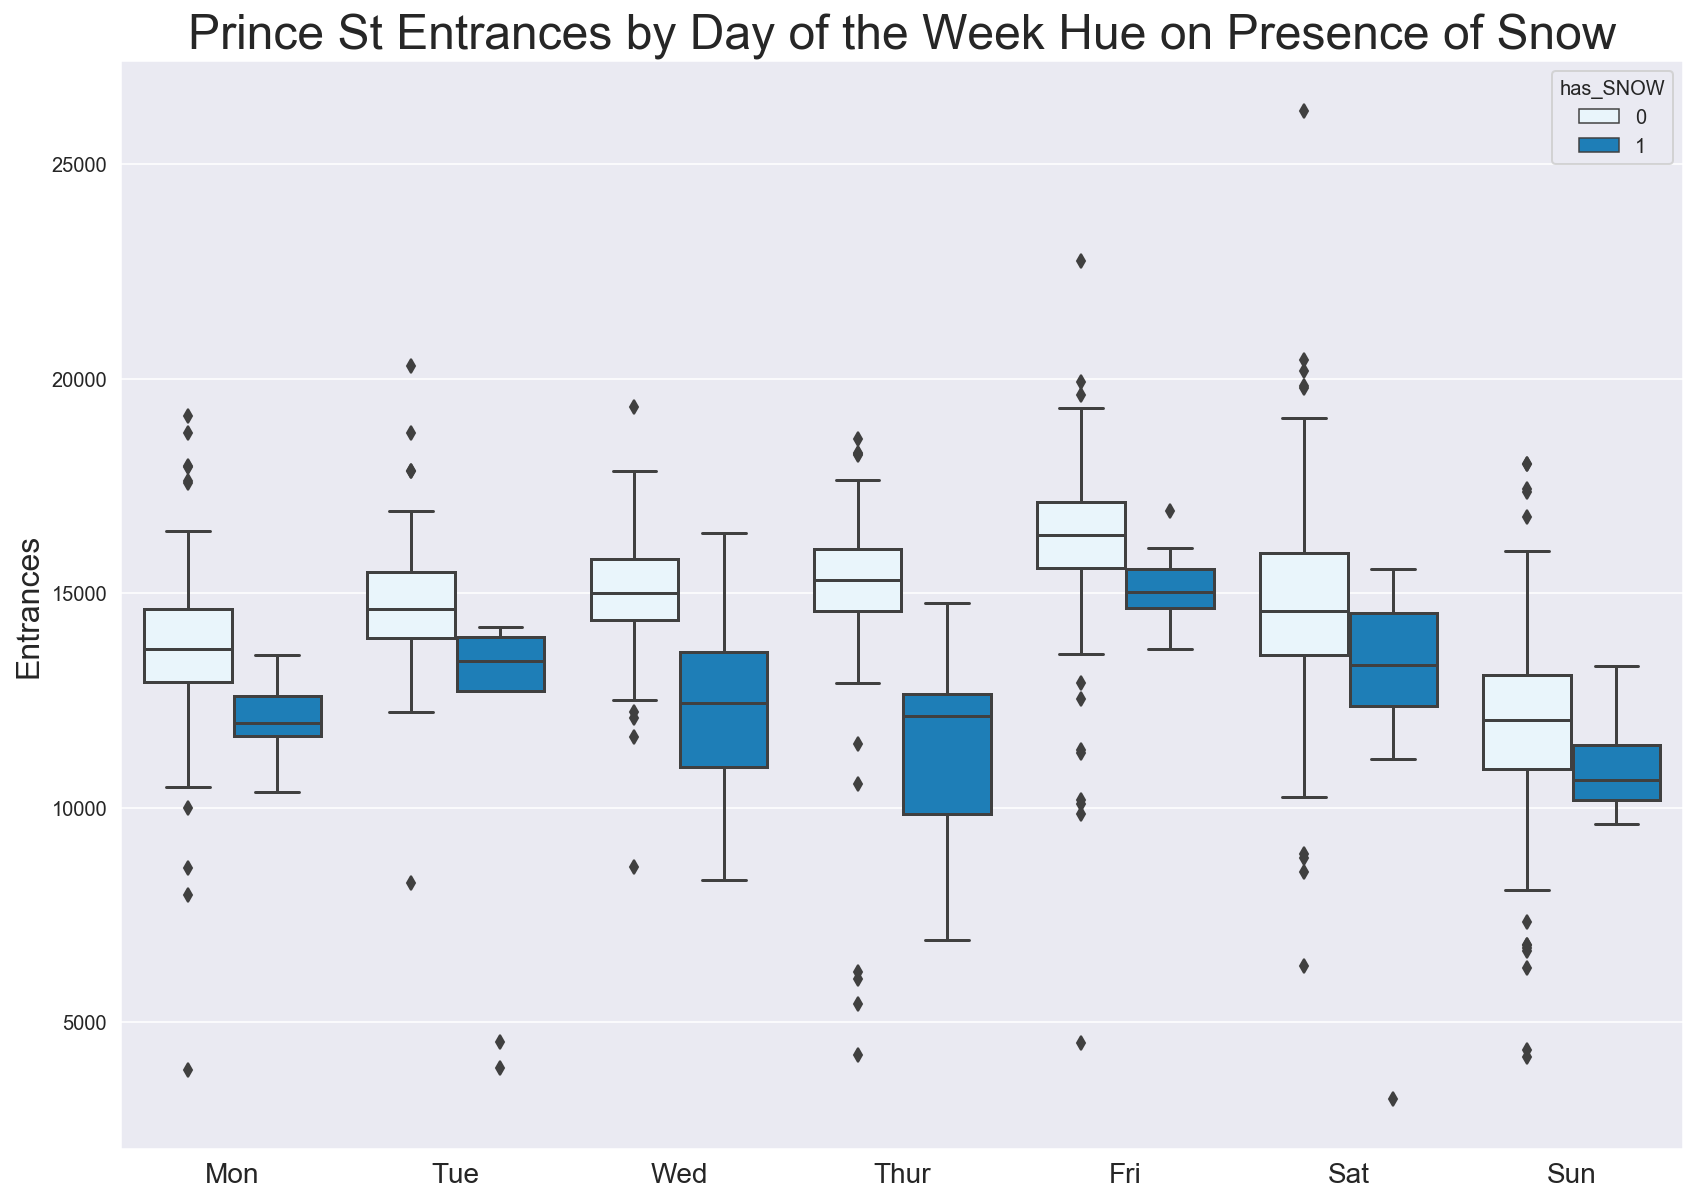

In [70]:
plt.figure(figsize=(14,10))
sns.boxplot(data=df, x='weekday', y='Hourly_Entries', hue='has_SNOW', color='#0485d1');
plt.title('Prince St Entrances by Day of the Week Hue on Presence of Snow', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('', fontsize=16);
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], fontsize=14);

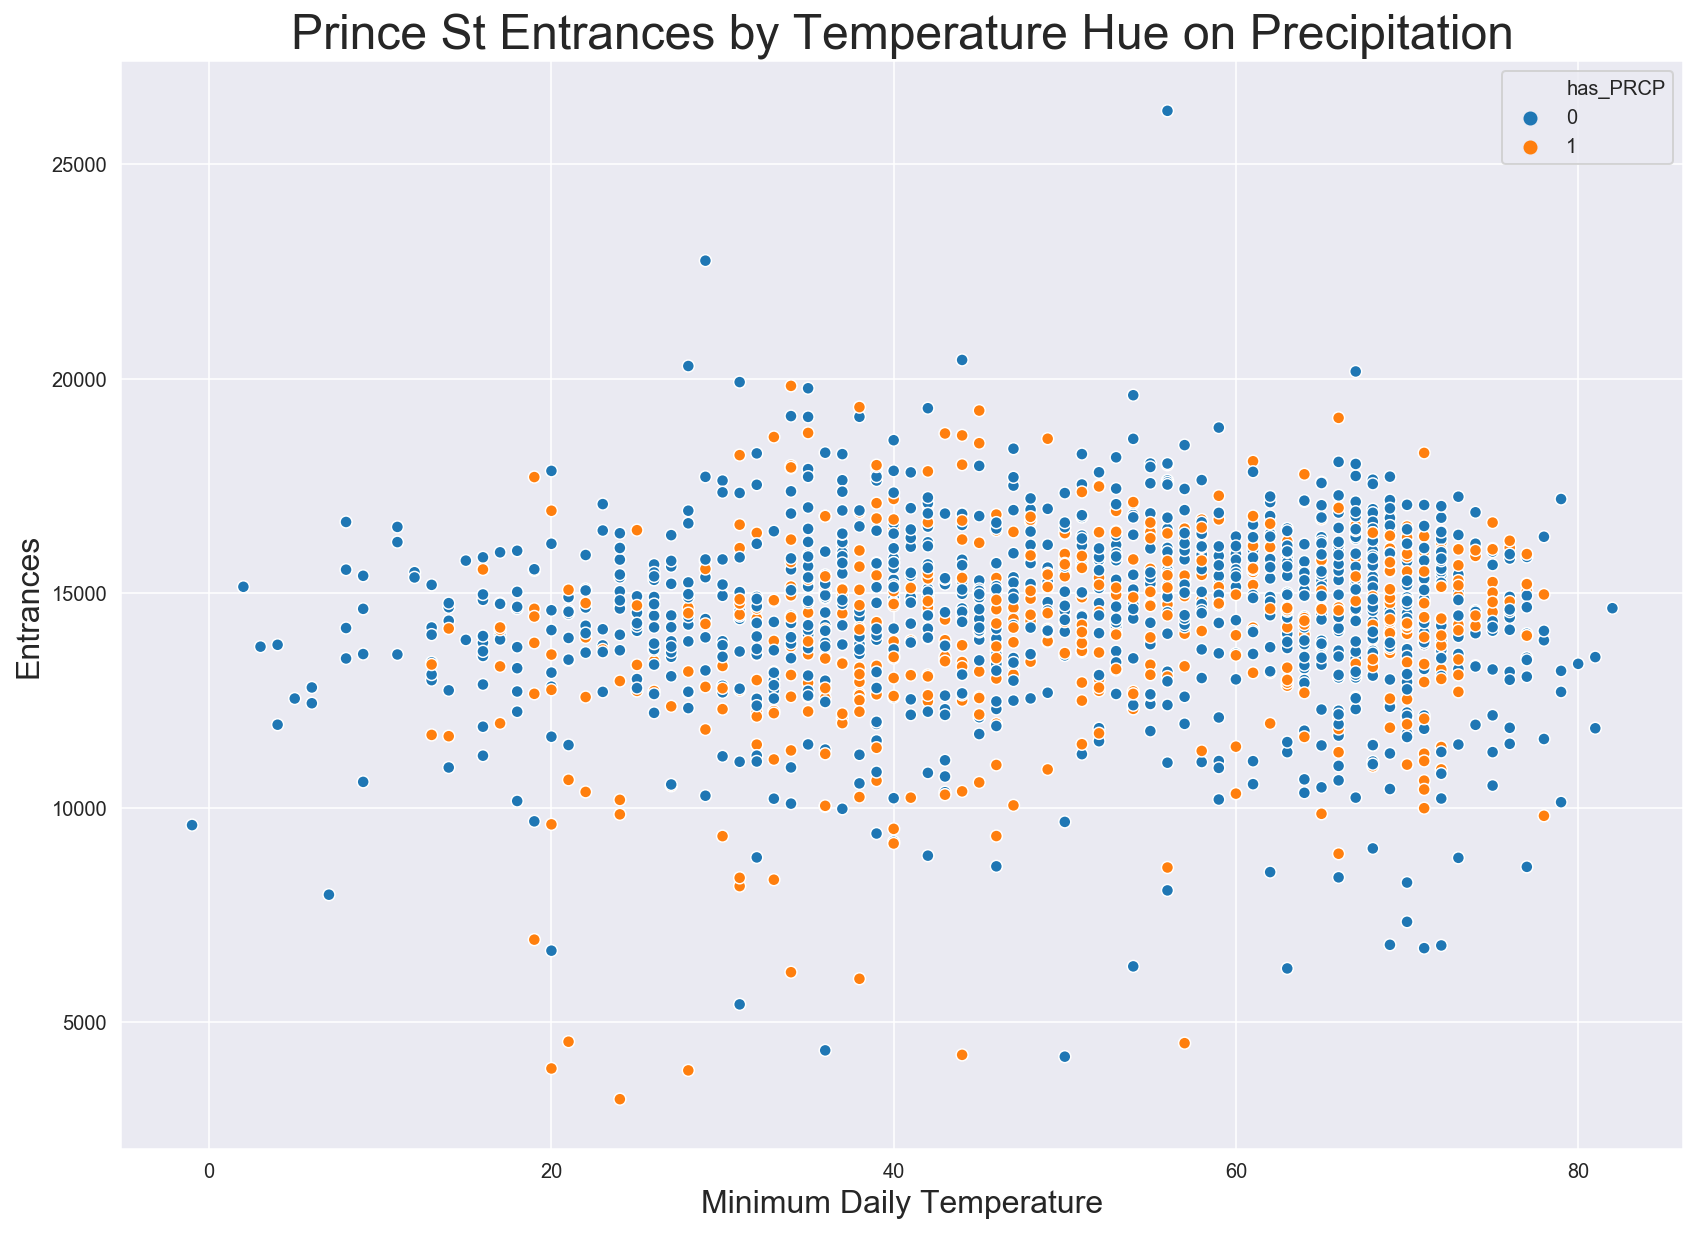

In [72]:
plt.figure(figsize=(14,10))
sns.scatterplot(data=df, x='TMIN', y='Hourly_Entries', hue='has_PRCP', color='#0485d1');
plt.title('Prince St Entrances by Temperature Hue on Precipitation', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Minimum Daily Temperature', fontsize=16);

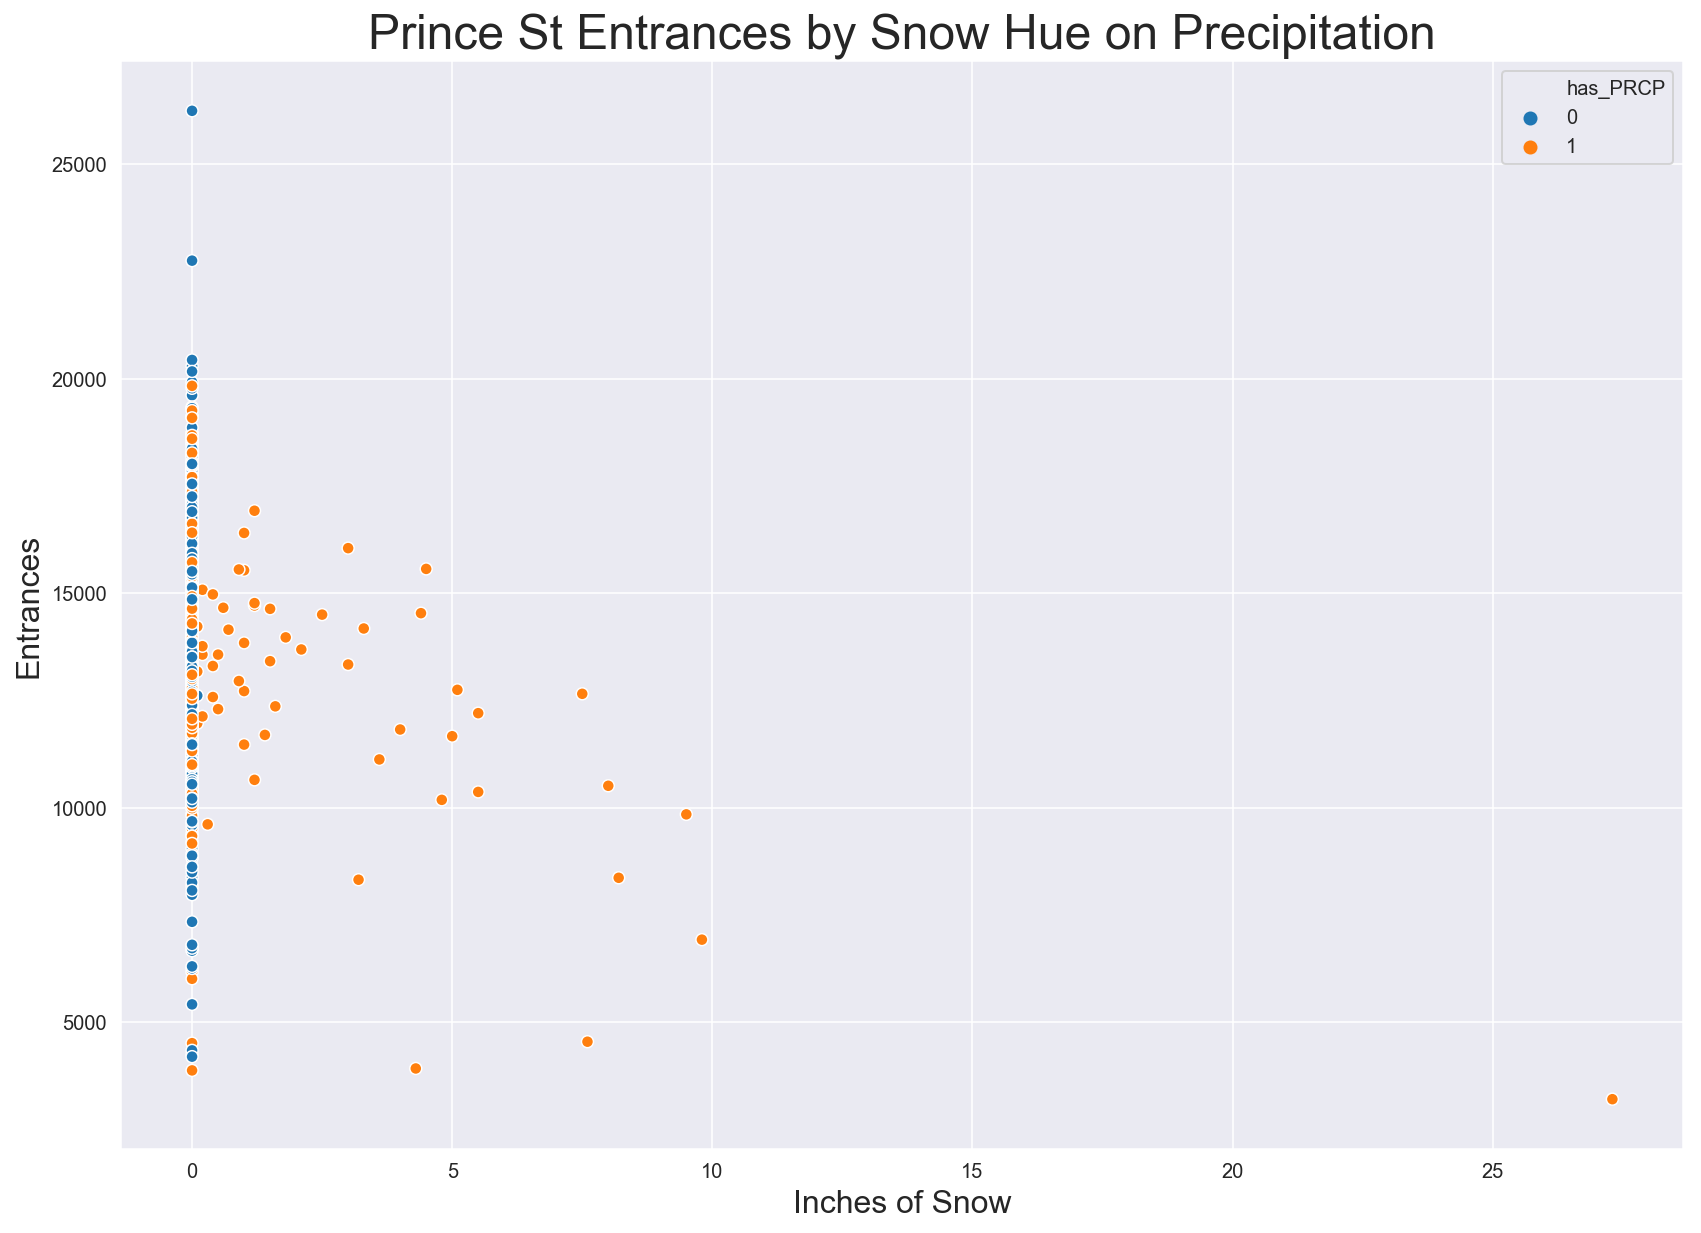

In [68]:
plt.figure(figsize=(14,10))
sns.scatterplot(data=df, x='SNOW', y='Hourly_Entries', hue='has_PRCP', color='#0485d1');
plt.title('Prince St Entrances by Snow Hue on Precipitation', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Inches of Snow', fontsize=16);

In [95]:
# create a dataframe with the lag columns removed
lag_mask = df.drop(columns= ['traffic_lag_1',
       'traffic_lag_7', 'traffic_lag_14', 'traffic_lag_21', 'traffic_lag_28',
       'Entries_lag_1', 'Entires_lag_7', 'Entires_lag_14', 'Entires_lag_21',
       'Entires_lag_28', 'Exits_lag_1', 'Exits_lag_7', 'Exits_lag_14',
       'Exits_lag_21', 'Exits_lag_28'])

In [96]:
# remove the Date column as it's datetime and will break the code below
lag_mask.drop(columns=['Date'], inplace=True)

### Box Plots and Joint Plots
Create box plots for each columns against the target Hourly_Entries for columns with less than 30 different entries while creating joint plots for those with greater than 30 different entries. The boxplots are all sorted by the mean of the category. 

Column: weekday ************************************


6    227
4    227
3    227
2    227
1    227
0    227
5    213
Name: weekday, dtype: int64

NAs: 0


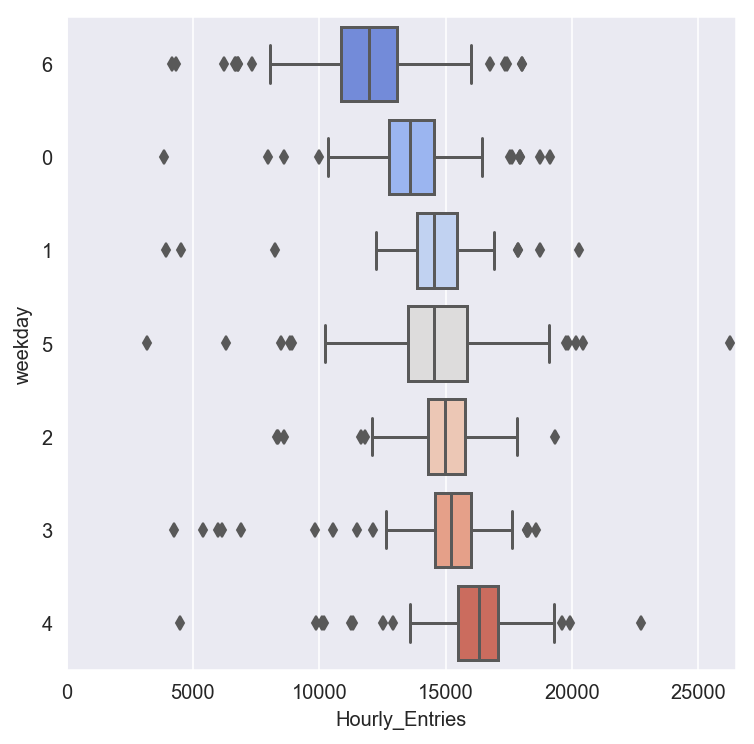

Column: Year ************************************


2015    342
2014    334
2016    333
2017    309
2018    257
Name: Year, dtype: int64

NAs: 0


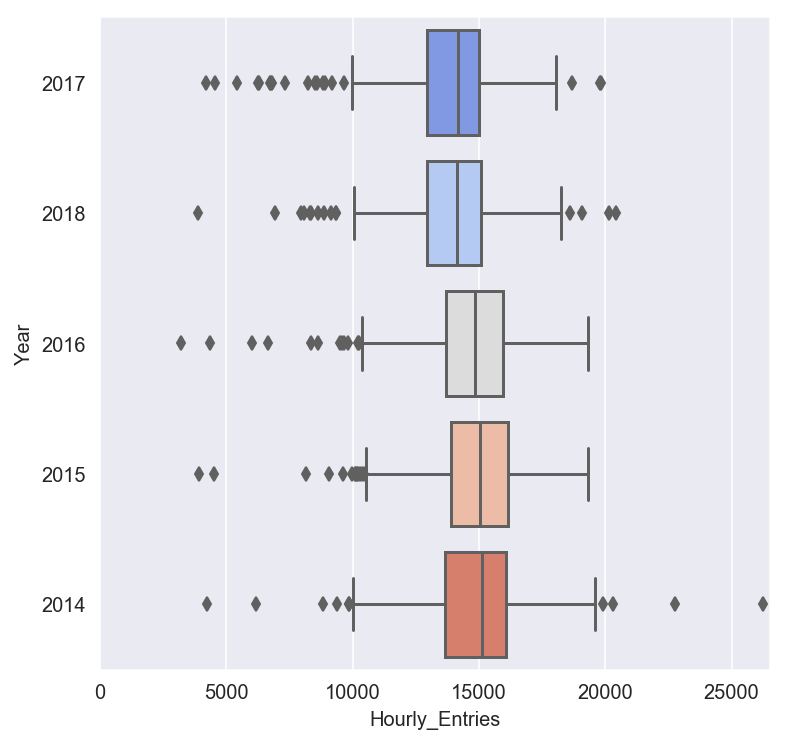

Column: traffic ************************************
NAs: 0


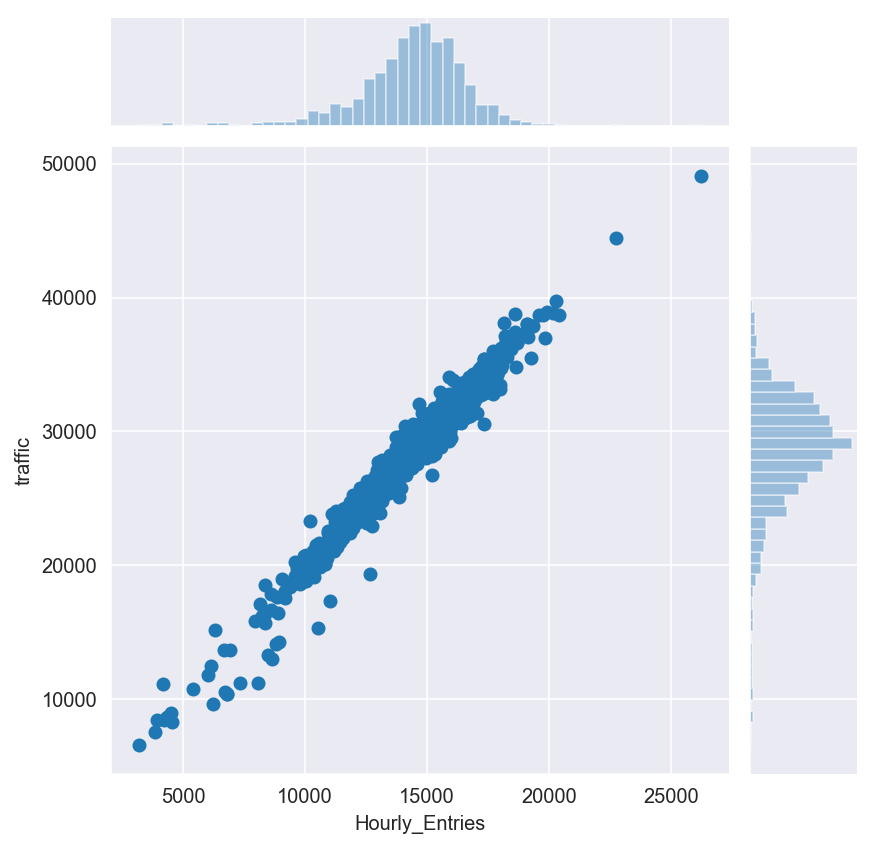

Column: Hourly_Entries ************************************
NAs: 0


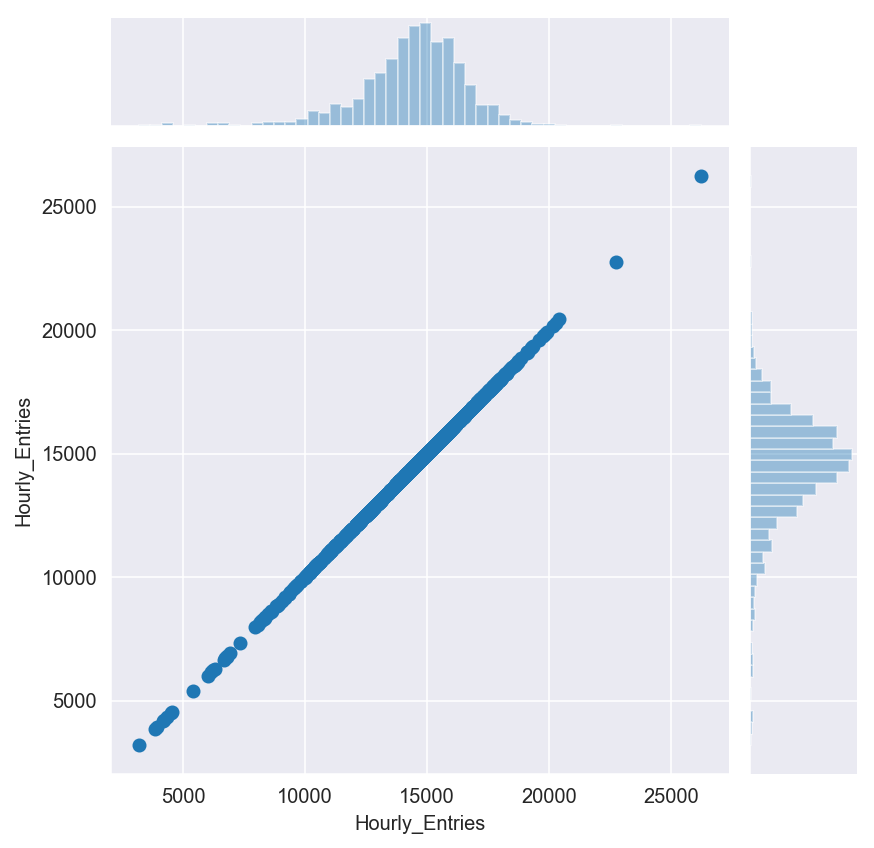

Column: Hourly_Exits ************************************
NAs: 0


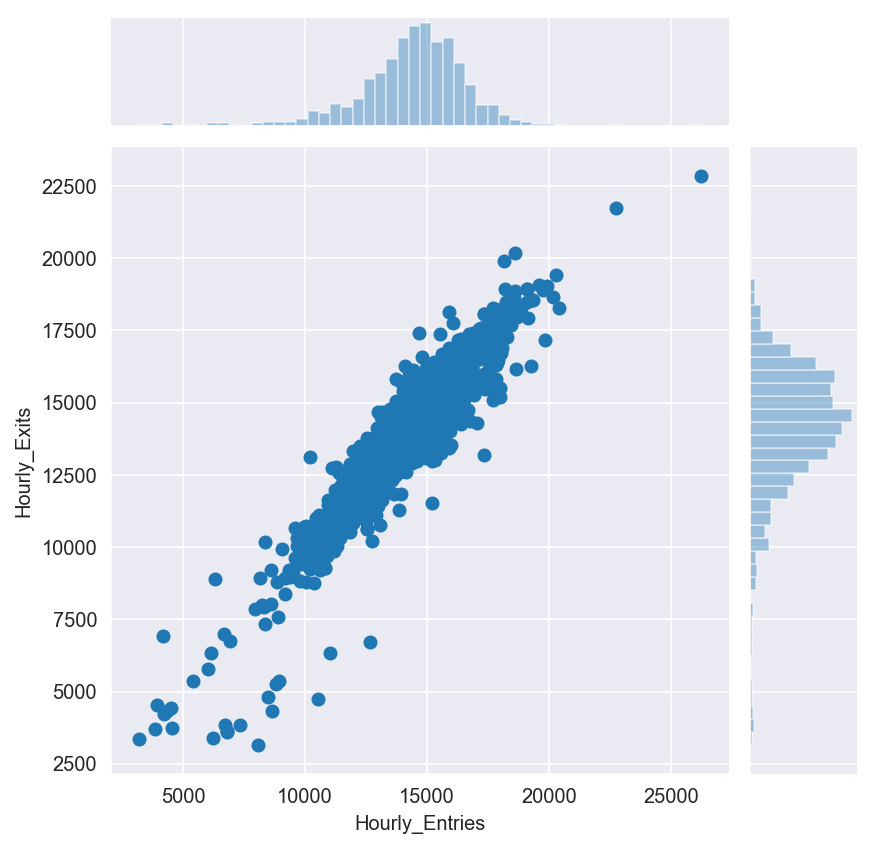

Column: month ************************************


8     155
5     155
4     150
7     146
3     139
2     133
9     125
1     124
6     120
10    116
12    108
11    104
Name: month, dtype: int64

NAs: 0


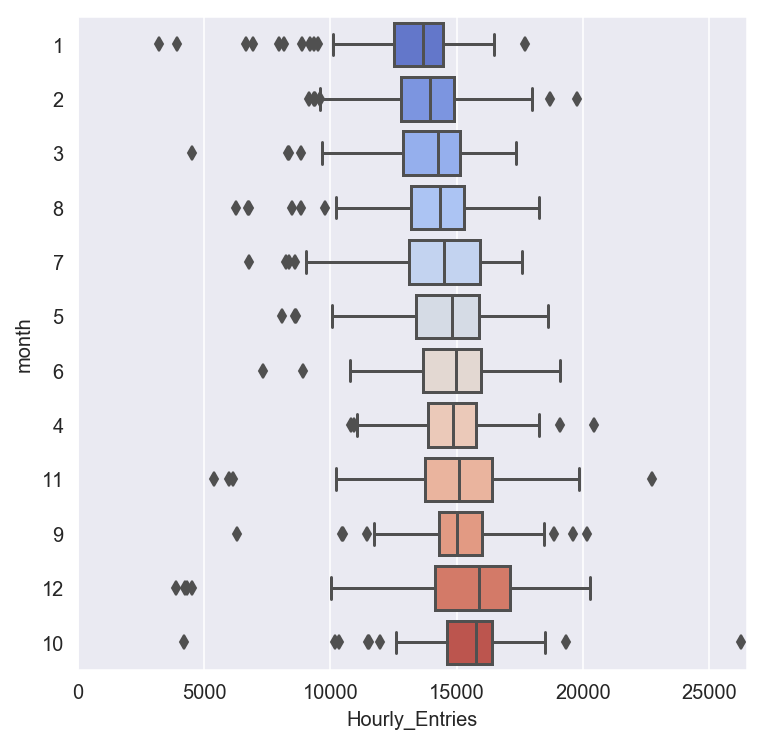

Column: year ************************************


2015    341
2016    335
2014    334
2017    317
2018    248
Name: year, dtype: int64

NAs: 0


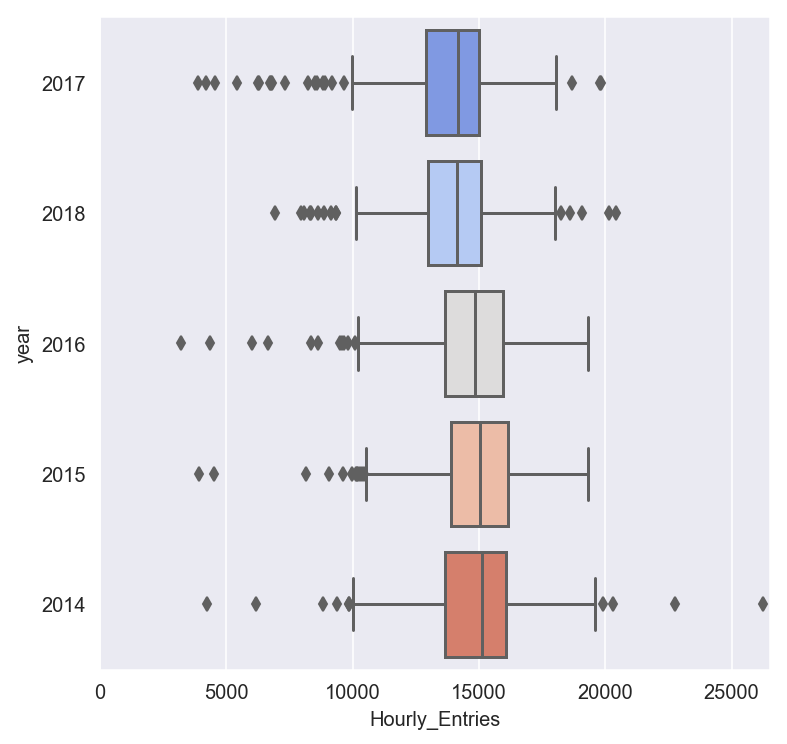

Column: is_Monday ************************************


0    1348
1     227
Name: is_Monday, dtype: int64

NAs: 0


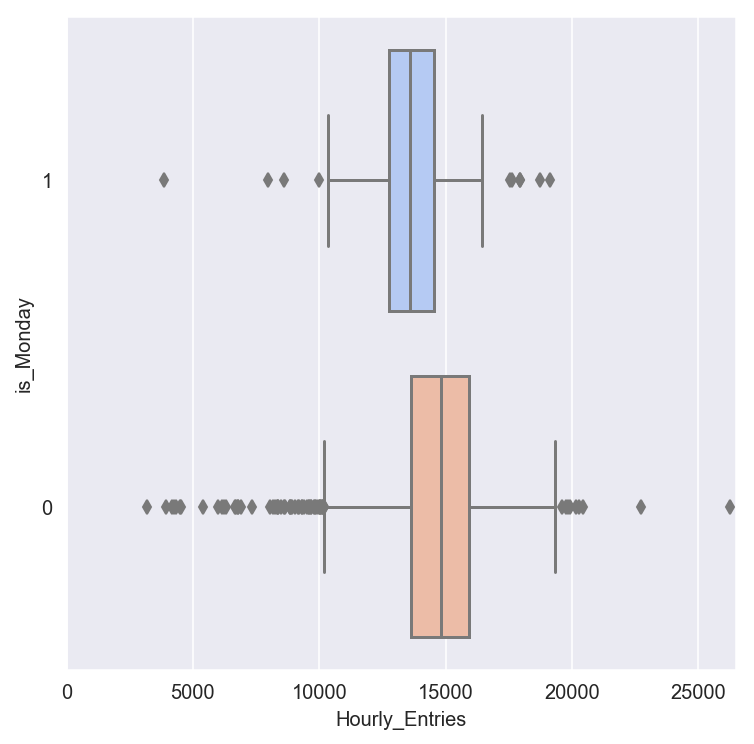

Column: is_Tuesday ************************************


0    1348
1     227
Name: is_Tuesday, dtype: int64

NAs: 0


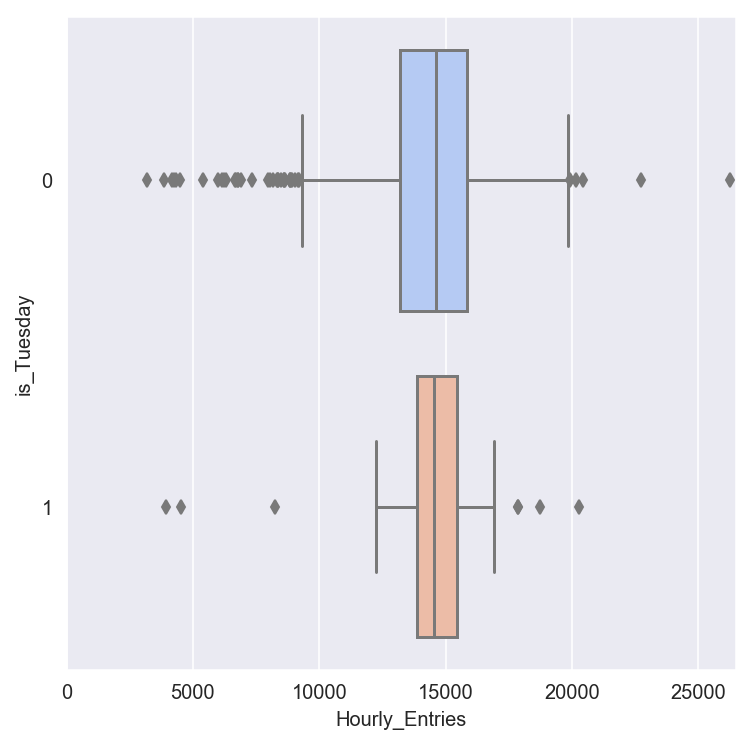

Column: is_Wednesday ************************************


0    1348
1     227
Name: is_Wednesday, dtype: int64

NAs: 0


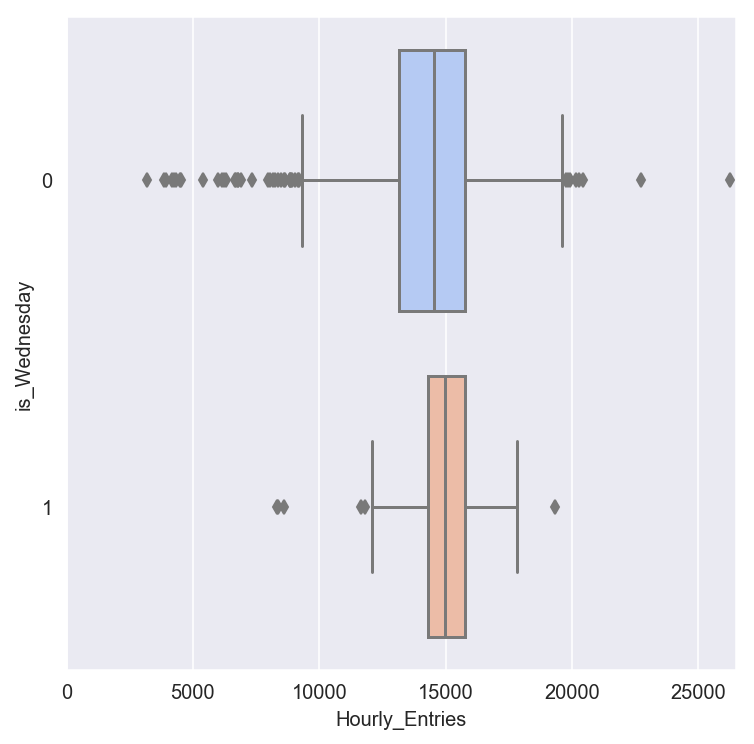

Column: is_Thursday ************************************


0    1348
1     227
Name: is_Thursday, dtype: int64

NAs: 0


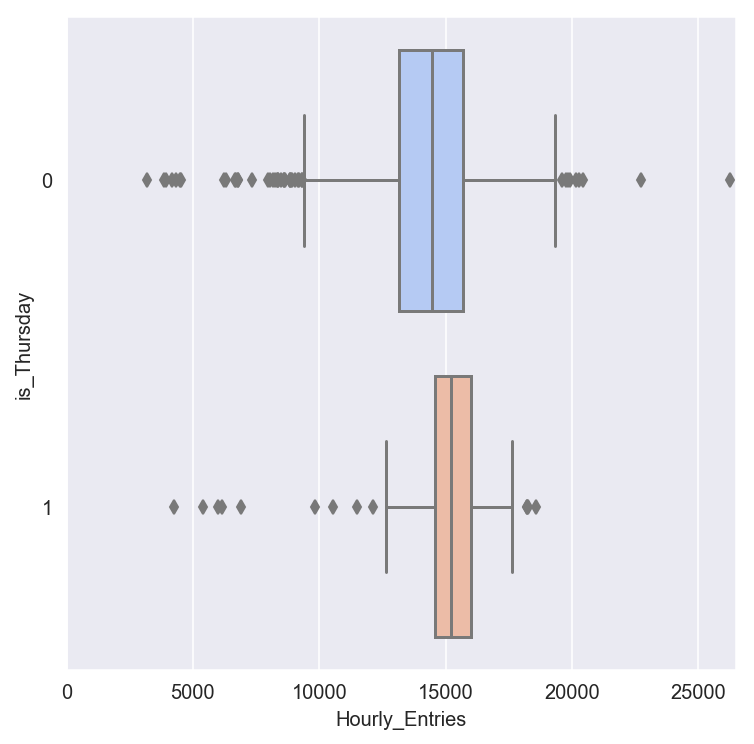

Column: is_Friday ************************************


0    1348
1     227
Name: is_Friday, dtype: int64

NAs: 0


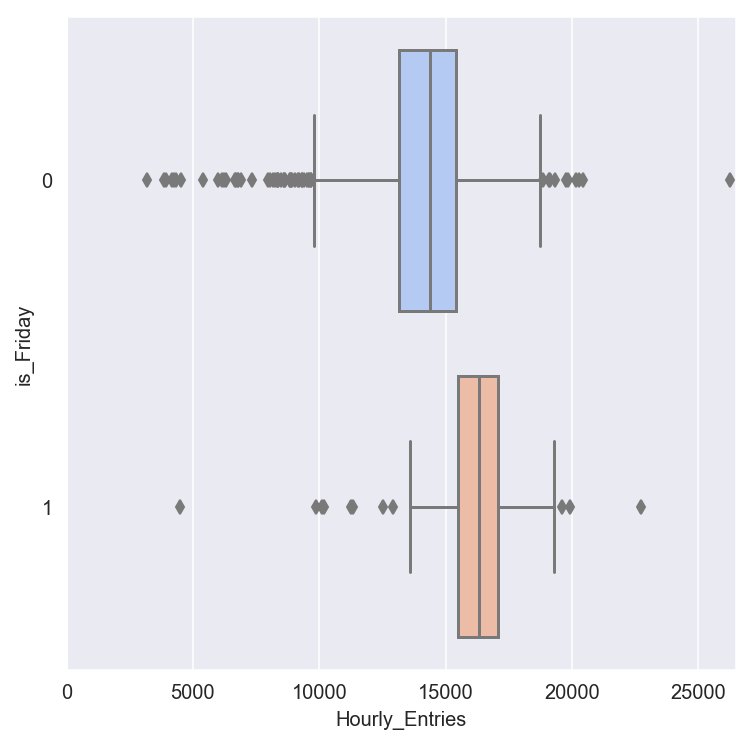

Column: is_Saturday ************************************


0    1362
1     213
Name: is_Saturday, dtype: int64

NAs: 0


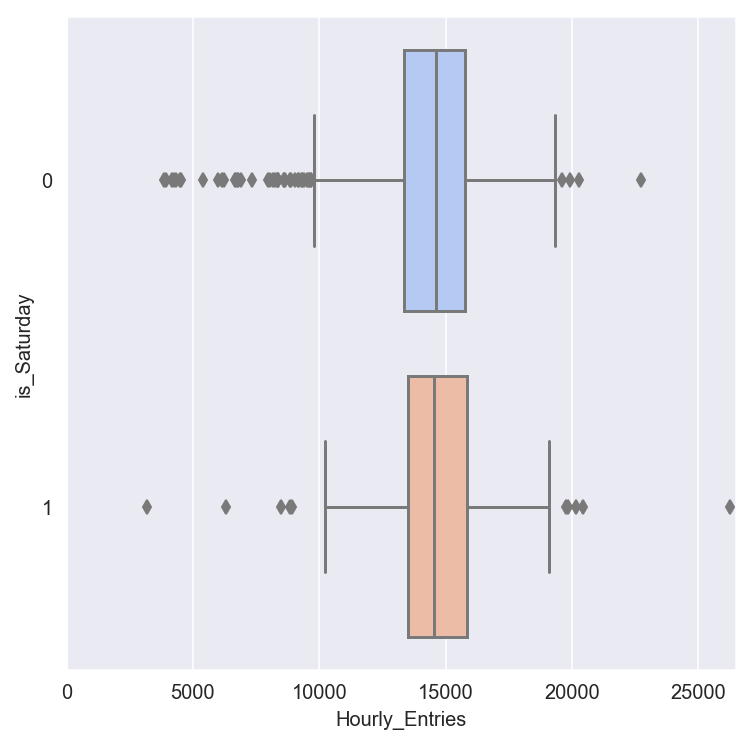

Column: is_Sunday ************************************


0    1348
1     227
Name: is_Sunday, dtype: int64

NAs: 0


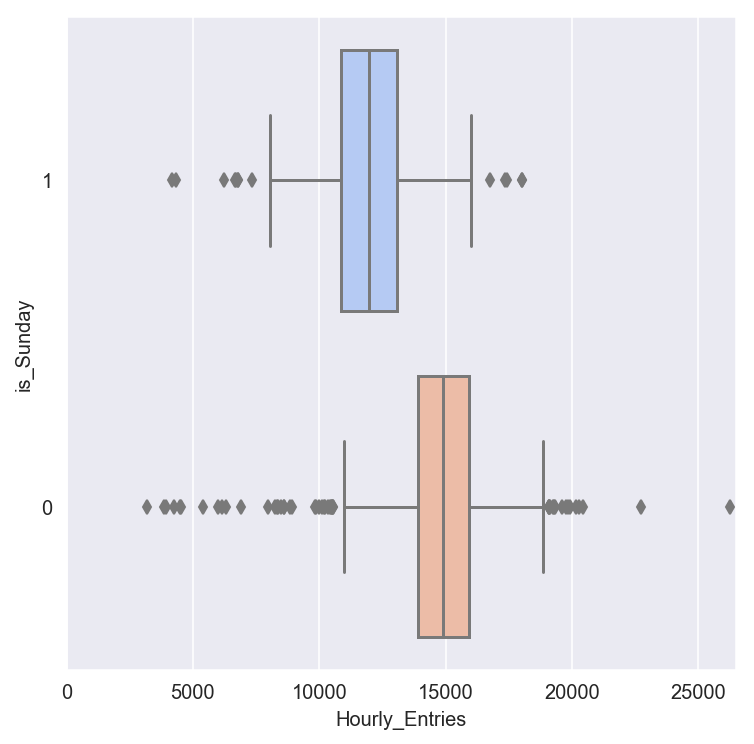

Column: is_Jan ************************************


0    1451
1     124
Name: is_Jan, dtype: int64

NAs: 0


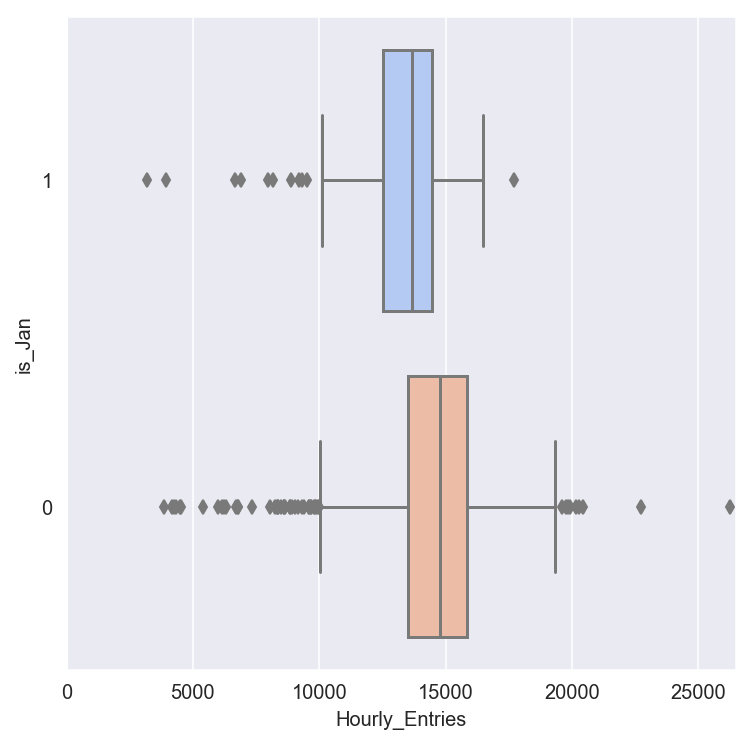

Column: is_Feb ************************************


0    1442
1     133
Name: is_Feb, dtype: int64

NAs: 0


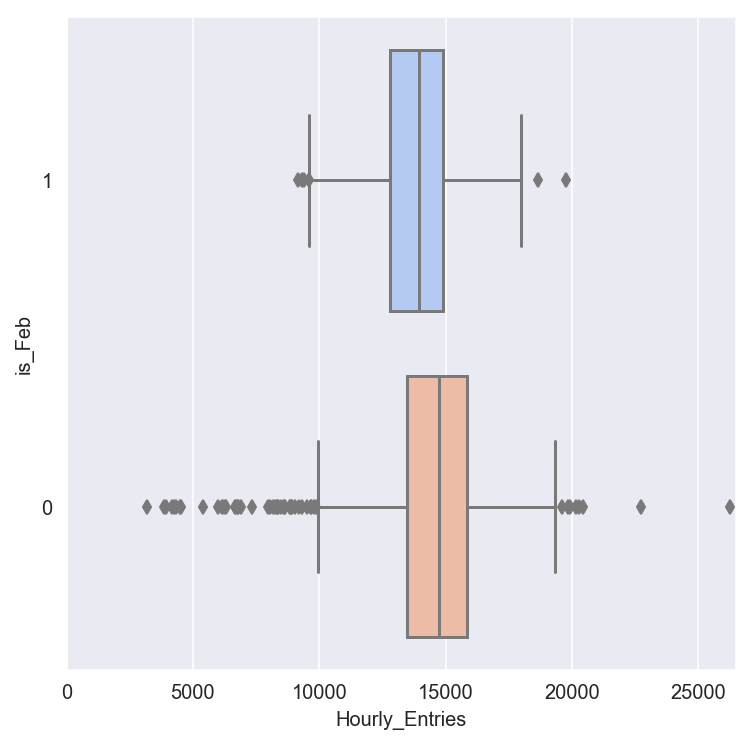

Column: is_Mar ************************************


0    1436
1     139
Name: is_Mar, dtype: int64

NAs: 0


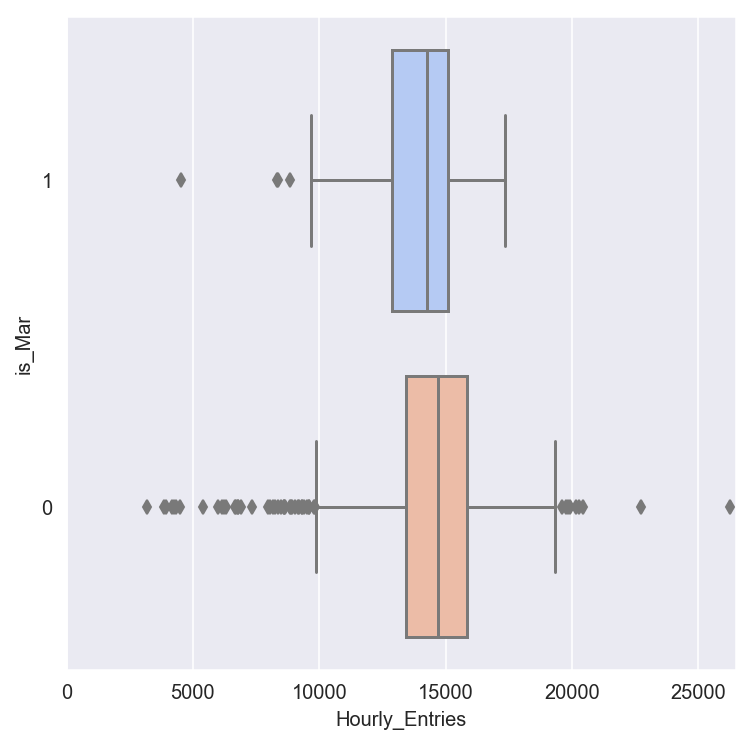

Column: is_Apr ************************************


0    1425
1     150
Name: is_Apr, dtype: int64

NAs: 0


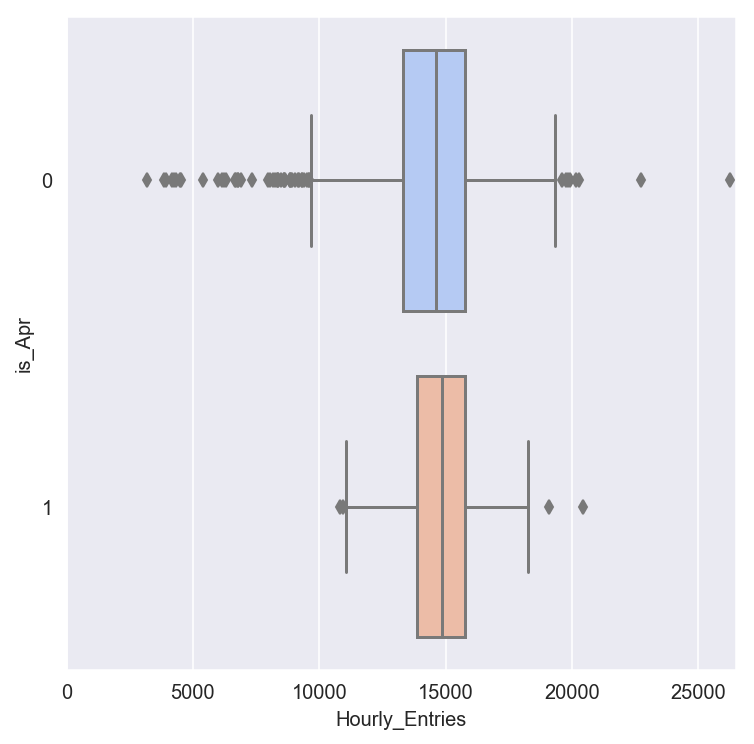

Column: is_May ************************************


0    1420
1     155
Name: is_May, dtype: int64

NAs: 0


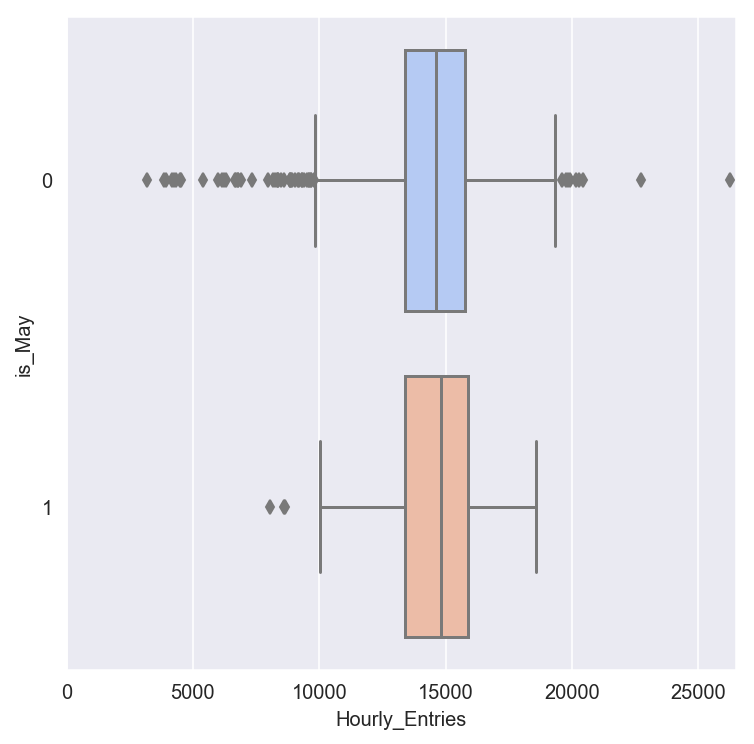

Column: is_Jun ************************************


0    1455
1     120
Name: is_Jun, dtype: int64

NAs: 0


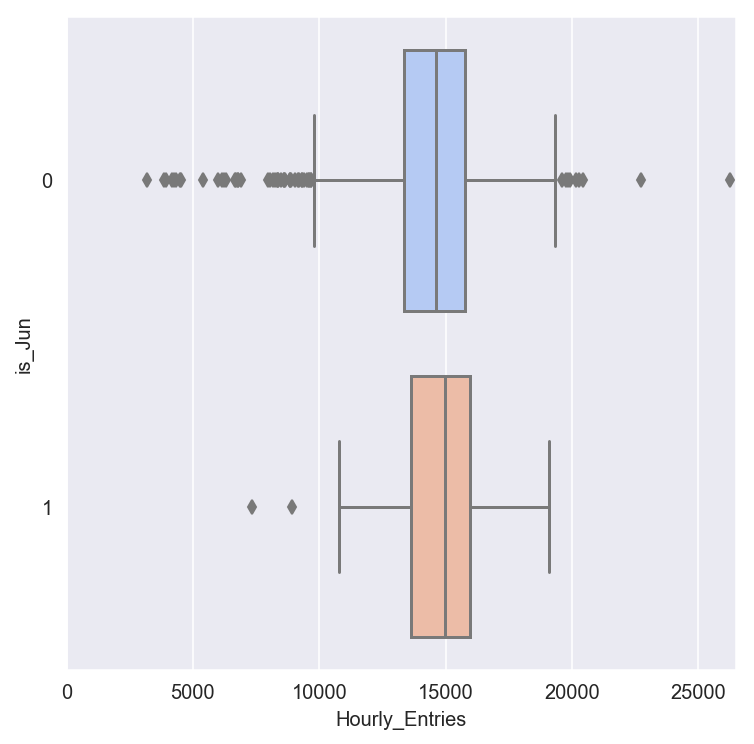

Column: is_Jul ************************************


0    1429
1     146
Name: is_Jul, dtype: int64

NAs: 0


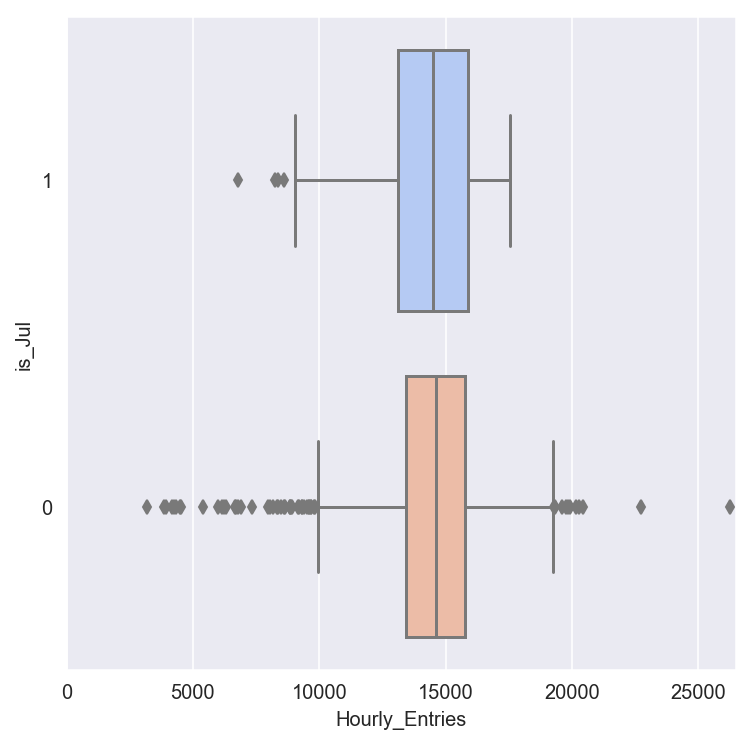

Column: is_Aug ************************************


0    1420
1     155
Name: is_Aug, dtype: int64

NAs: 0


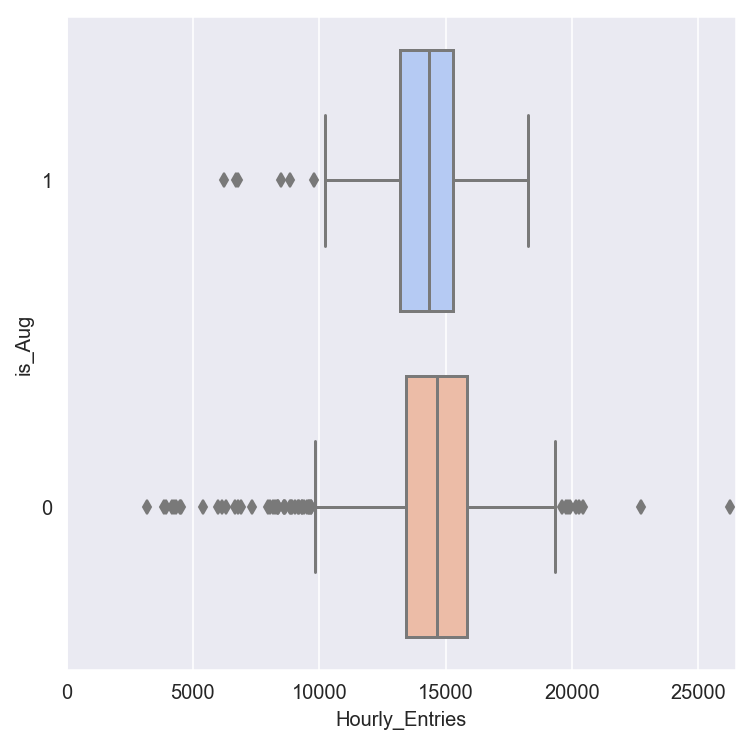

Column: is_Sep ************************************


0    1450
1     125
Name: is_Sep, dtype: int64

NAs: 0


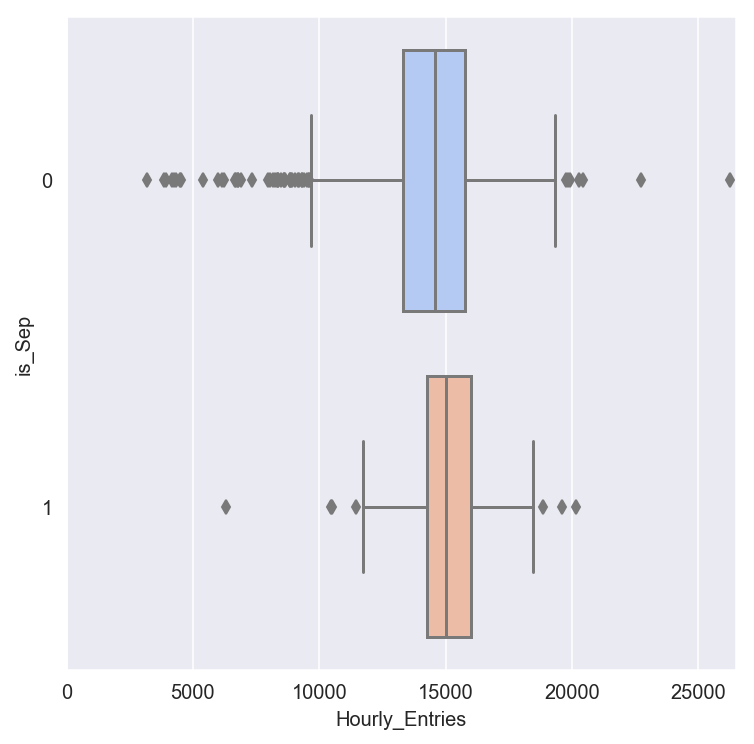

Column: is_Oct ************************************


0    1459
1     116
Name: is_Oct, dtype: int64

NAs: 0


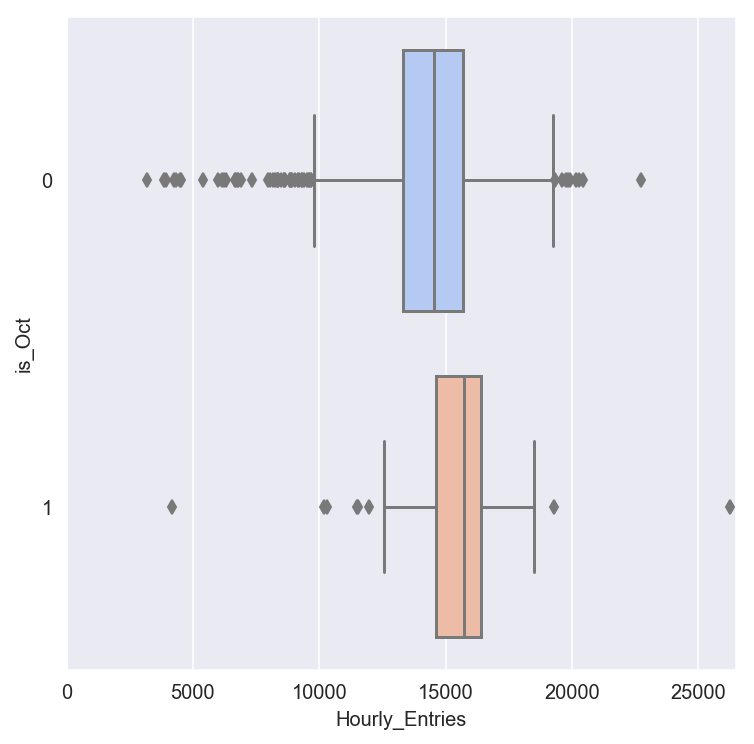

Column: is_Nov ************************************


0    1471
1     104
Name: is_Nov, dtype: int64

NAs: 0


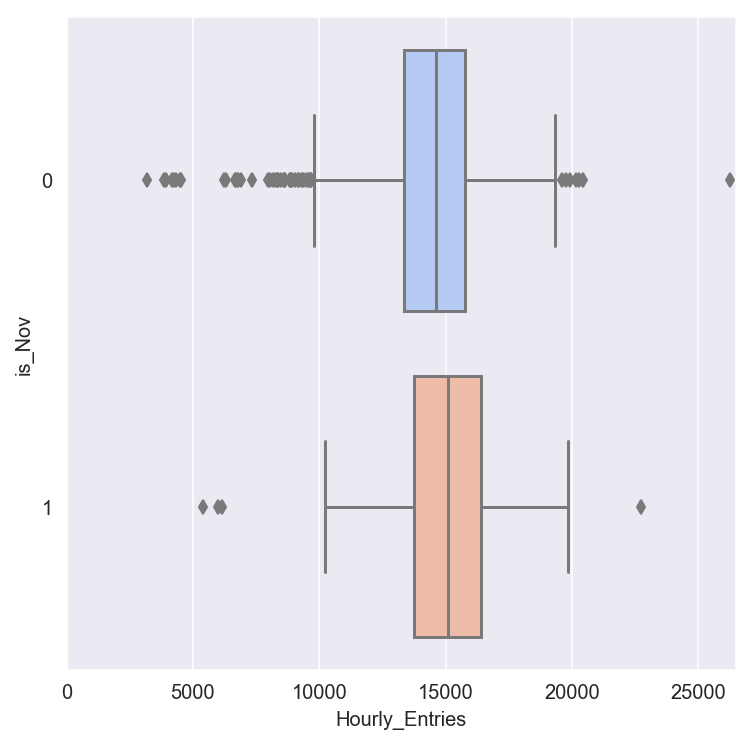

Column: is_Dec ************************************


0    1467
1     108
Name: is_Dec, dtype: int64

NAs: 0


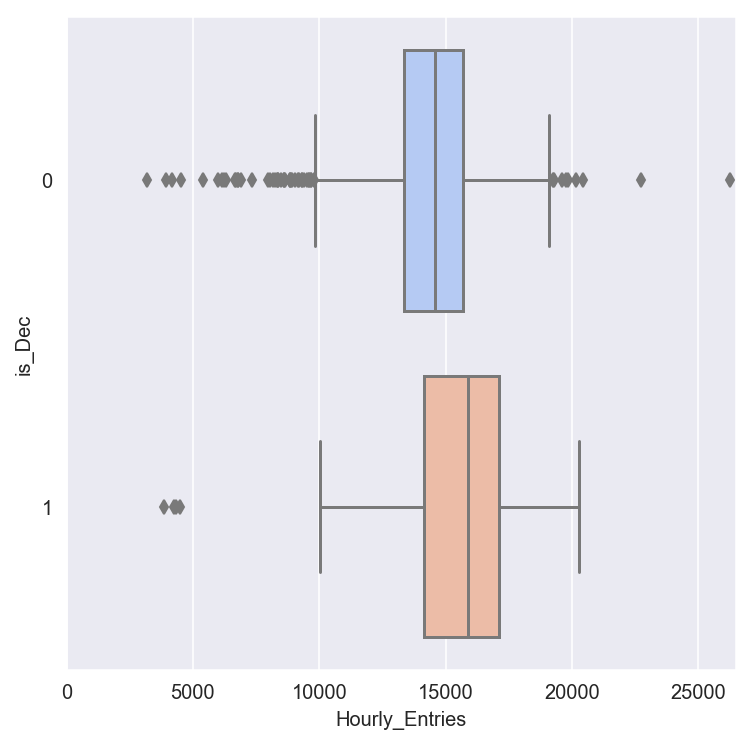

Column: is_New_Years ************************************


0    1571
1       4
Name: is_New_Years, dtype: int64

NAs: 0


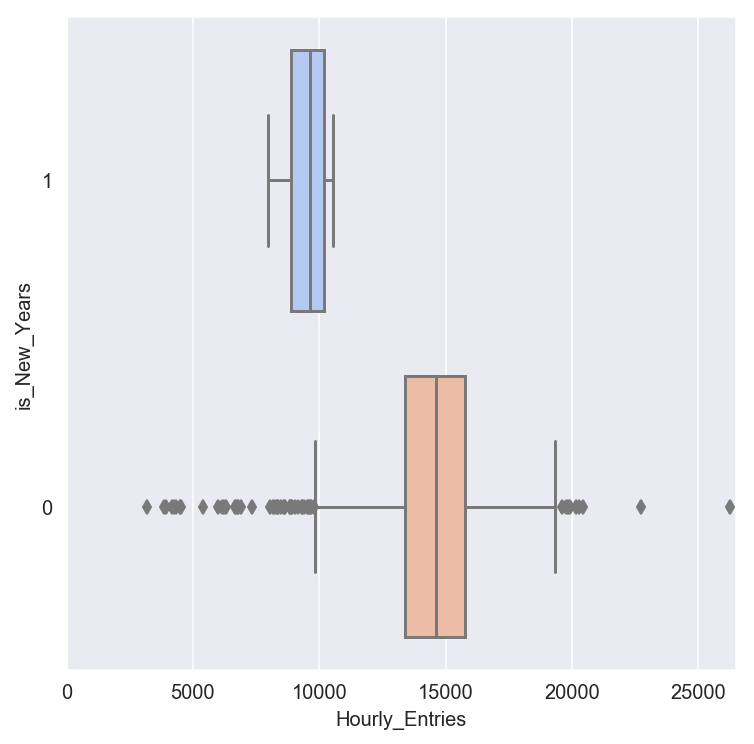

Column: is_MLK ************************************


0    1571
1       4
Name: is_MLK, dtype: int64

NAs: 0


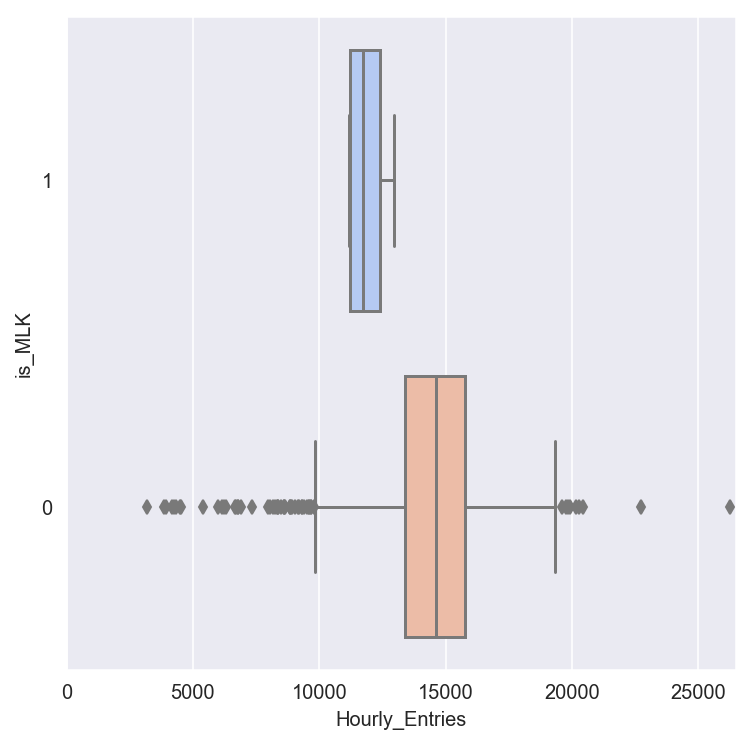

Column: is_Presidents_Day ************************************


0    1570
1       5
Name: is_Presidents_Day, dtype: int64

NAs: 0


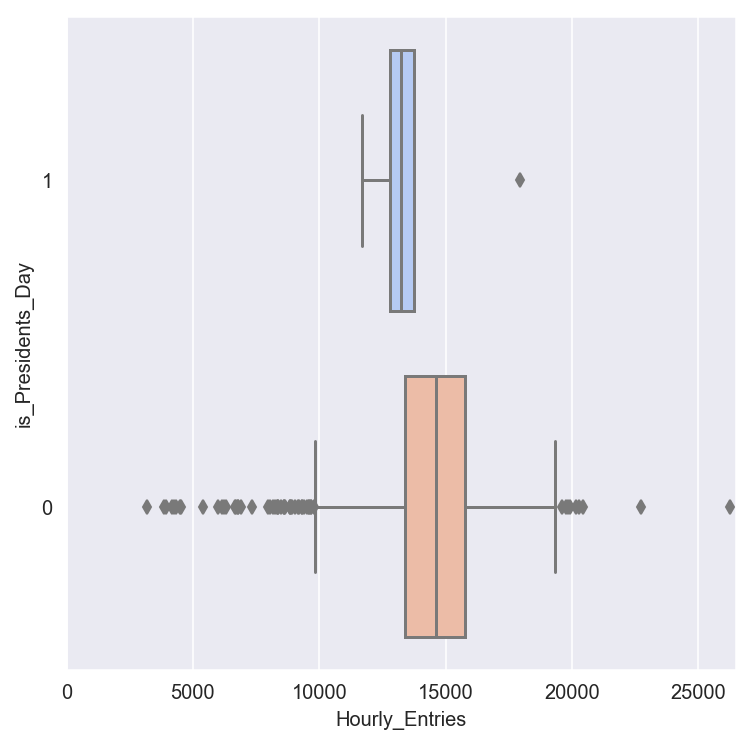

Column: is_Good_Friday ************************************


0    1570
1       5
Name: is_Good_Friday, dtype: int64

NAs: 0


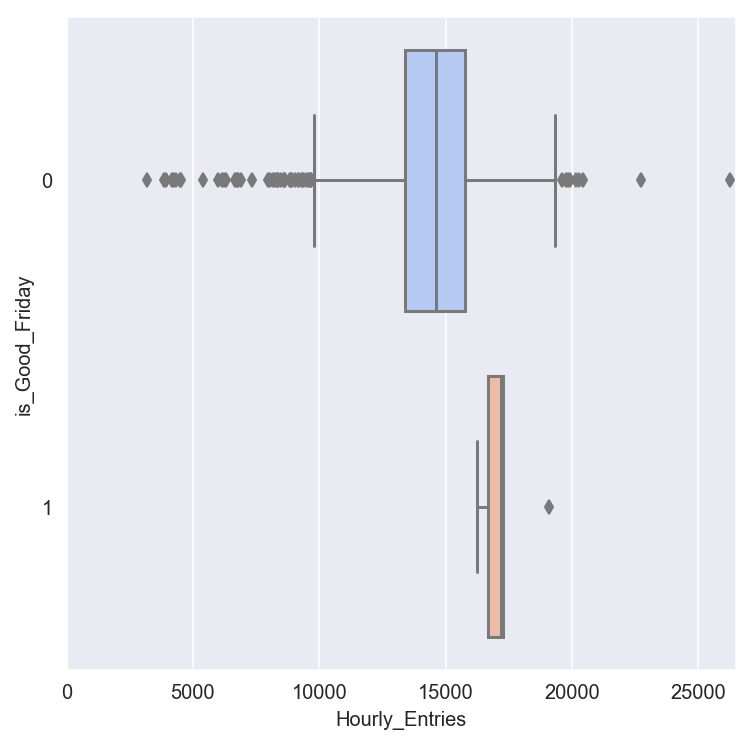

Column: is_Easter ************************************


0    1570
1       5
Name: is_Easter, dtype: int64

NAs: 0


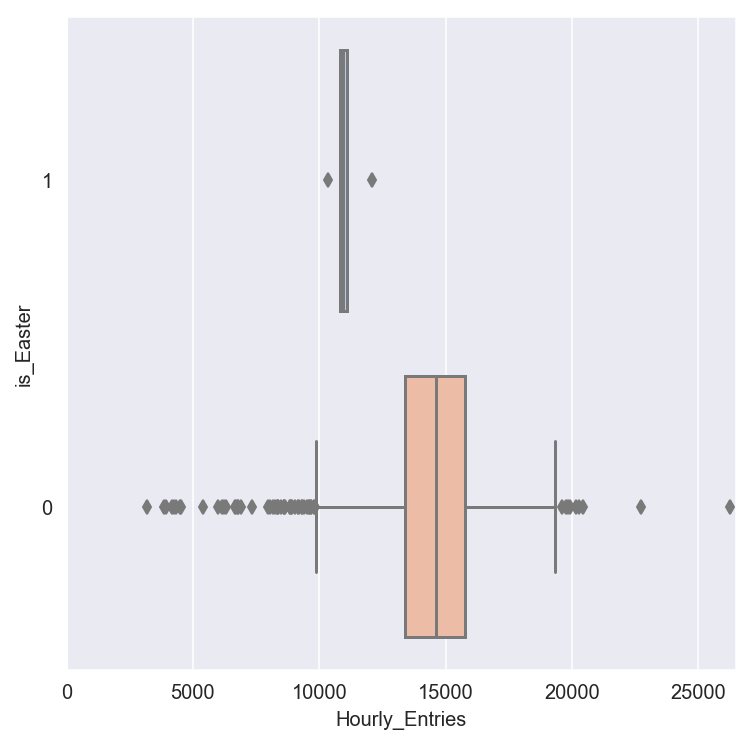

Column: is_Memorial_Day ************************************


0    1570
1       5
Name: is_Memorial_Day, dtype: int64

NAs: 0


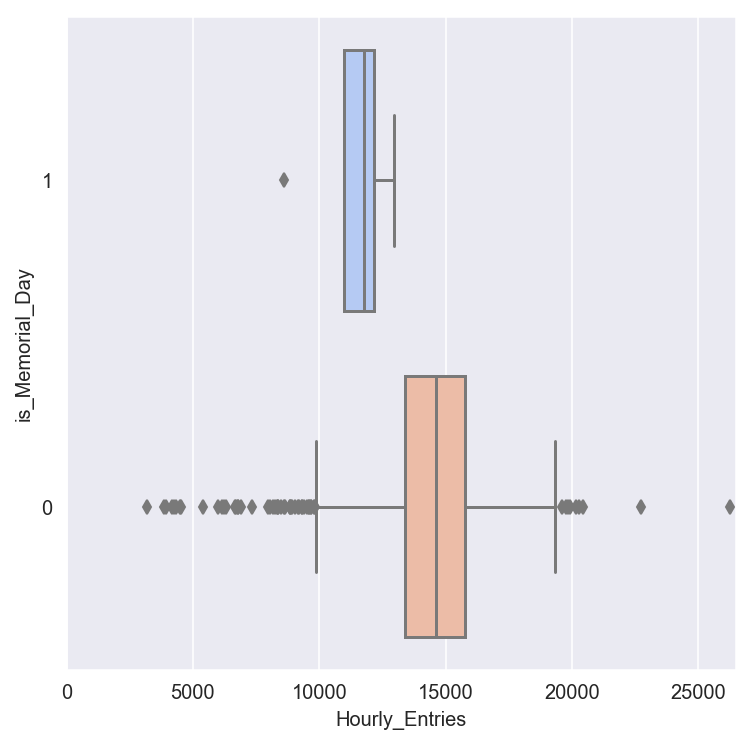

Column: is_Independence_Day ************************************


0    1571
1       4
Name: is_Independence_Day, dtype: int64

NAs: 0


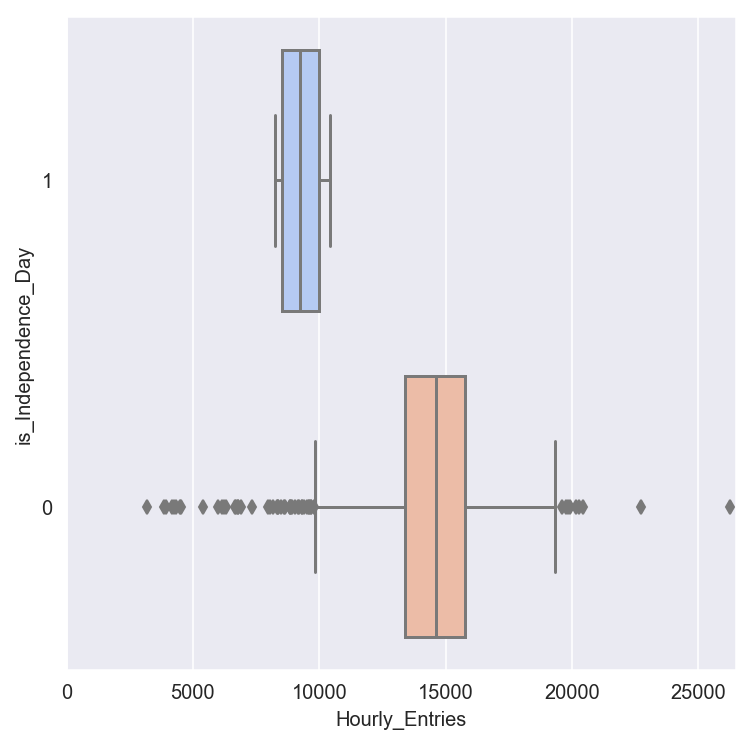

Column: is_Labor_Day ************************************


0    1572
1       3
Name: is_Labor_Day, dtype: int64

NAs: 0


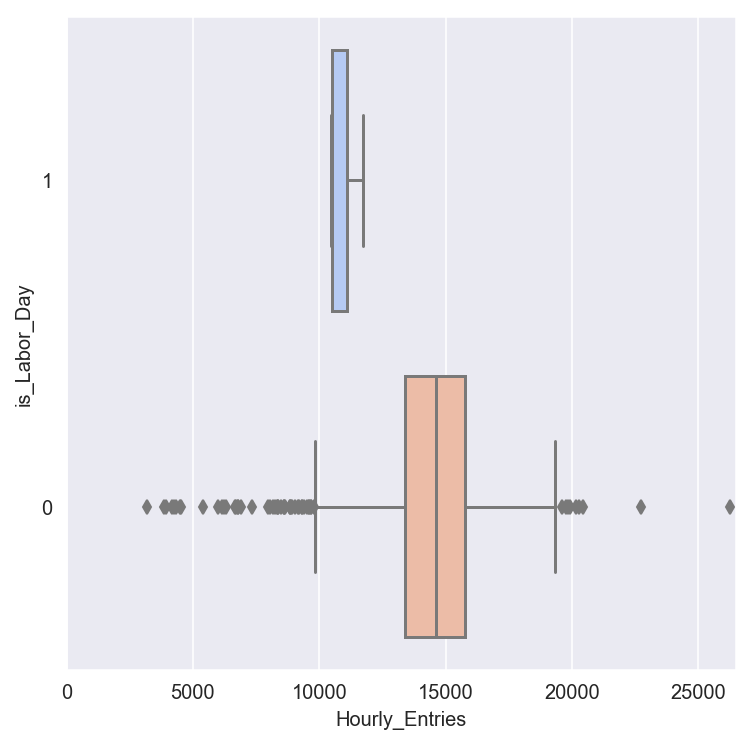

Column: is_Thanksgiving ************************************


0    1572
1       3
Name: is_Thanksgiving, dtype: int64

NAs: 0


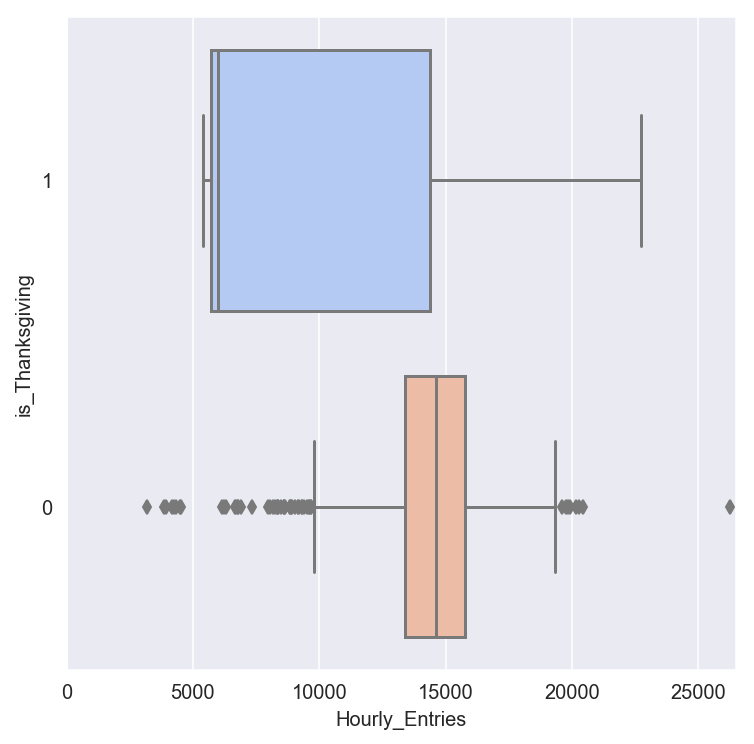

Column: is_Black_Friday ************************************


0    1572
1       3
Name: is_Black_Friday, dtype: int64

NAs: 0


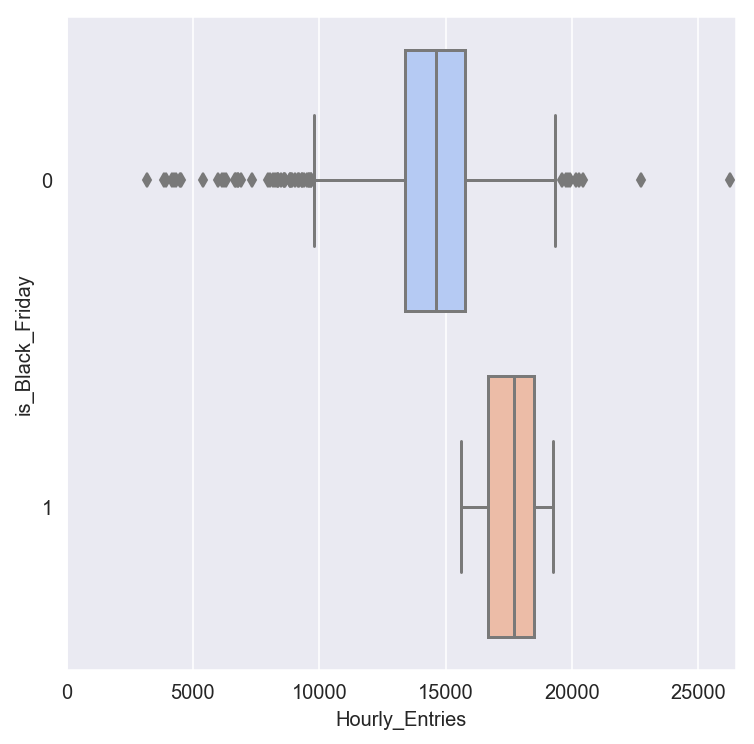

Column: is_Christmas_Eve ************************************


0    1571
1       4
Name: is_Christmas_Eve, dtype: int64

NAs: 0


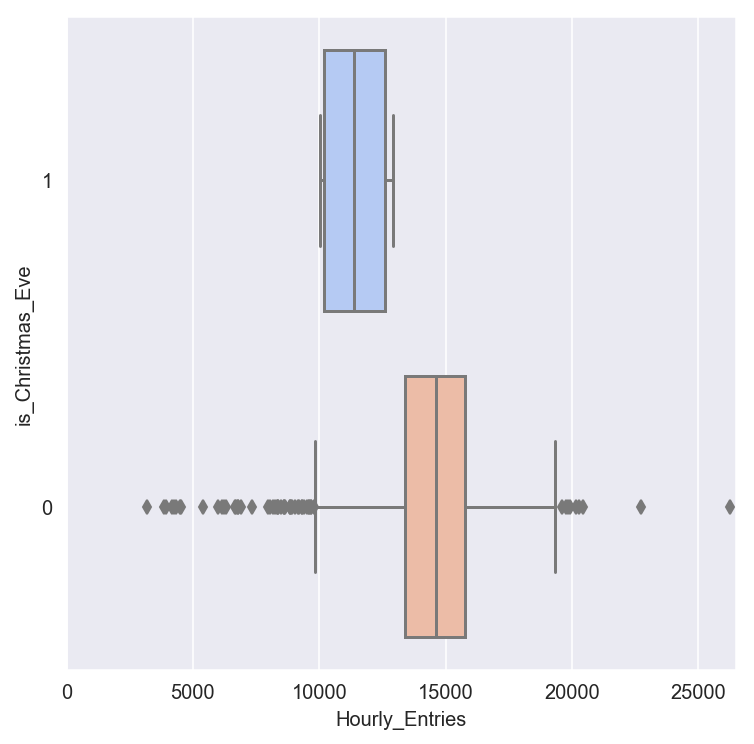

Column: is_Christmas ************************************


0    1571
1       4
Name: is_Christmas, dtype: int64

NAs: 0


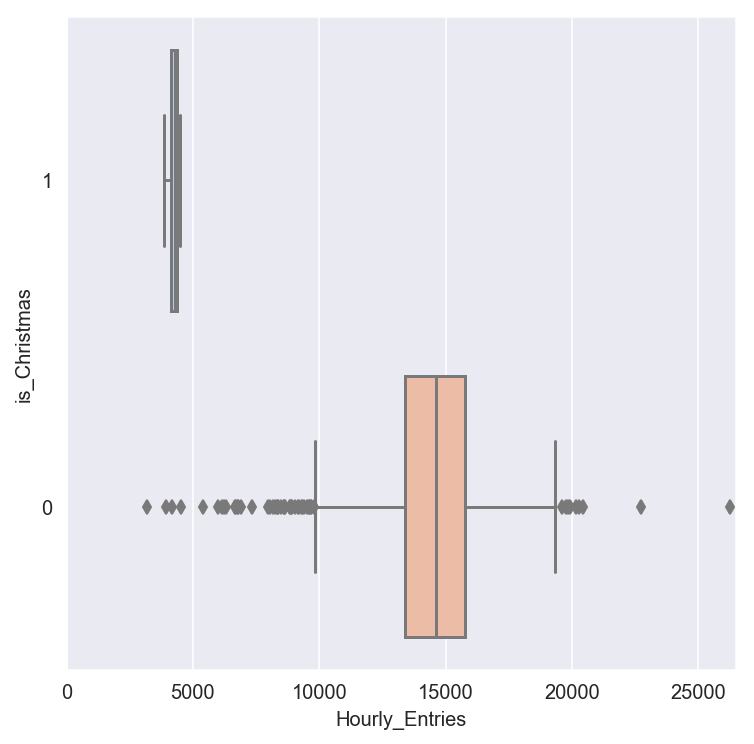

Column: is_NYE ************************************


0    1571
1       4
Name: is_NYE, dtype: int64

NAs: 0


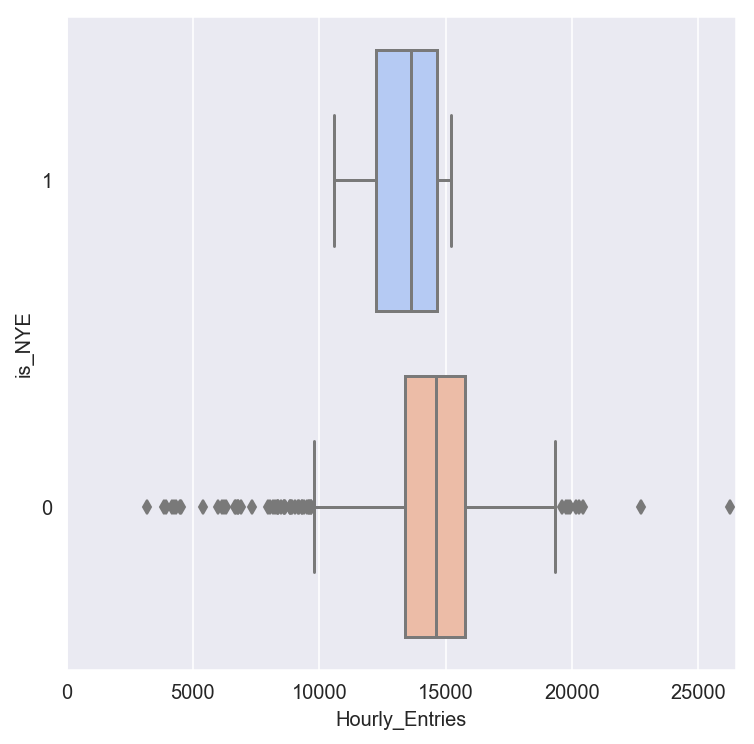

Column: is_weekend ************************************


0    1135
1     440
Name: is_weekend, dtype: int64

NAs: 0


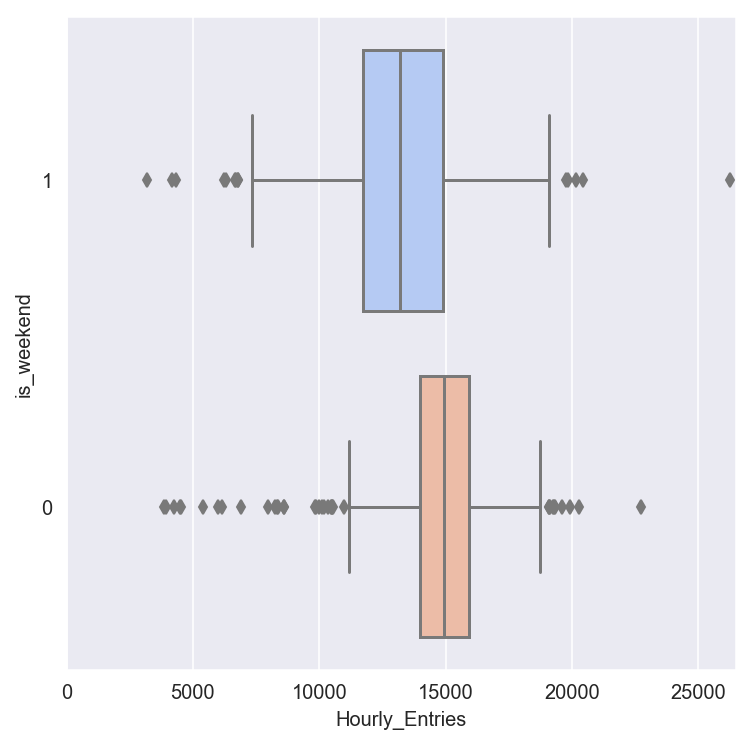

Column: PRCP ************************************
NAs: 0


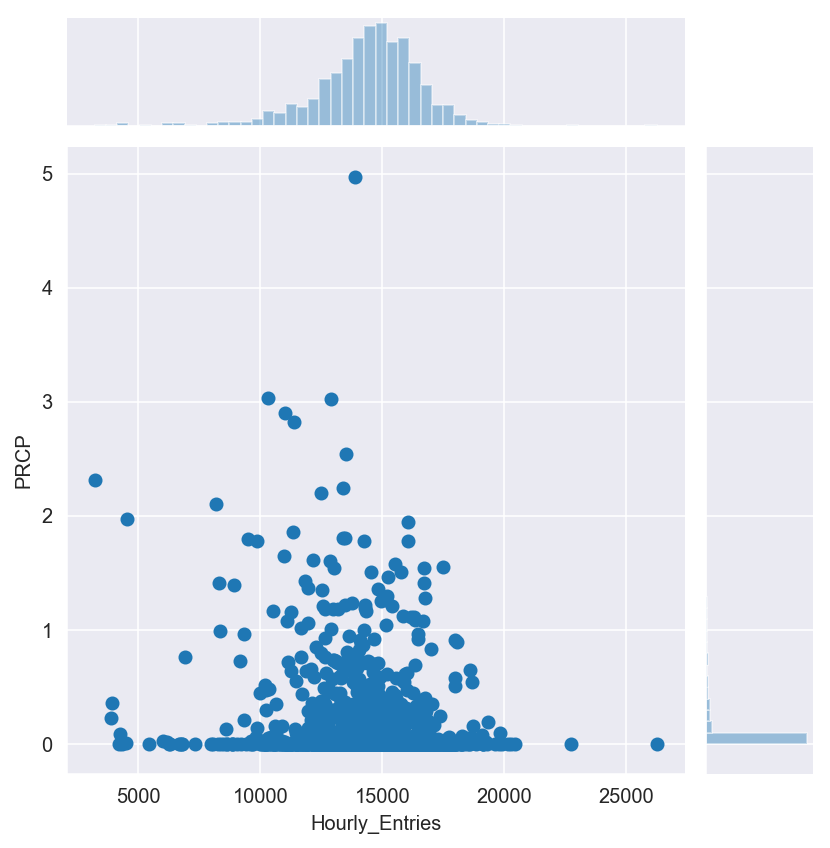

Column: PRCP_ATTRIBUTES ************************************


,,W,2400     1427
T,,W,2400      94
,,D,2400       45
T,,D,2400       9
Name: PRCP_ATTRIBUTES, dtype: int64

NAs: 0


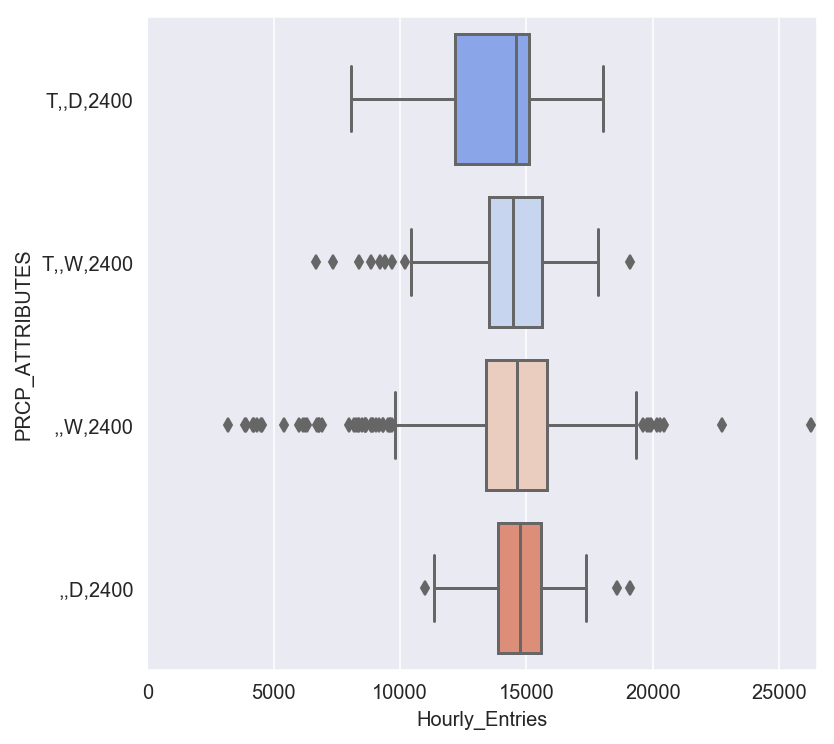

Column: SNOW ************************************
NAs: 0


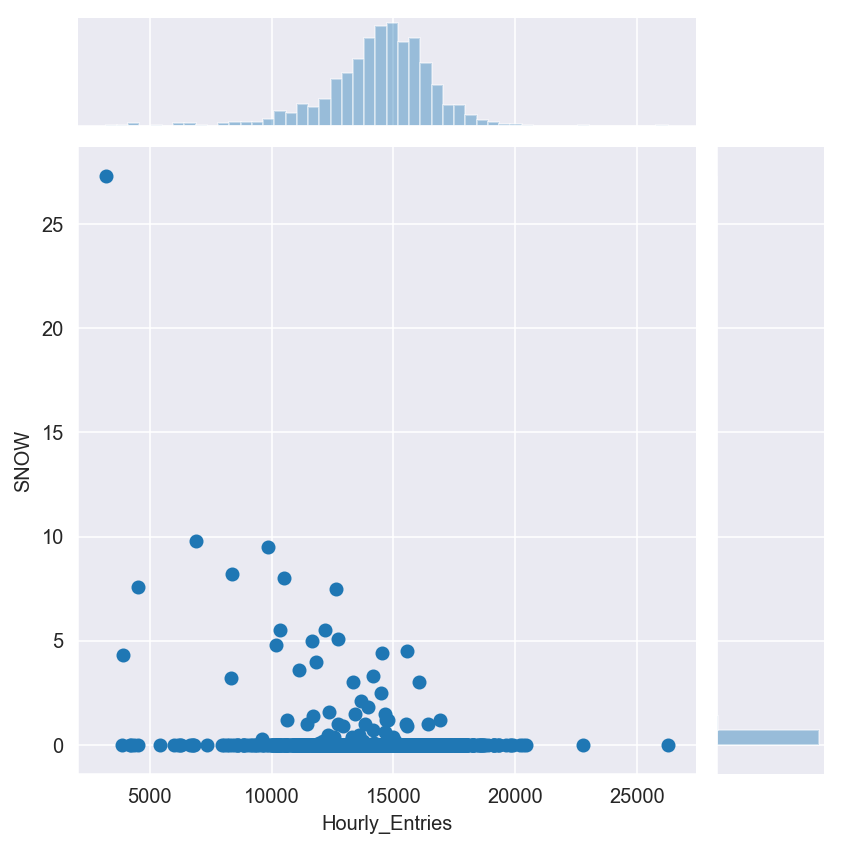

Column: SNOW_ATTRIBUTES ************************************


,,W,         794
,,W,2400     674
,,D,2400      54
T,,W,         36
T,,W,2400     17
Name: SNOW_ATTRIBUTES, dtype: int64

NAs: 0


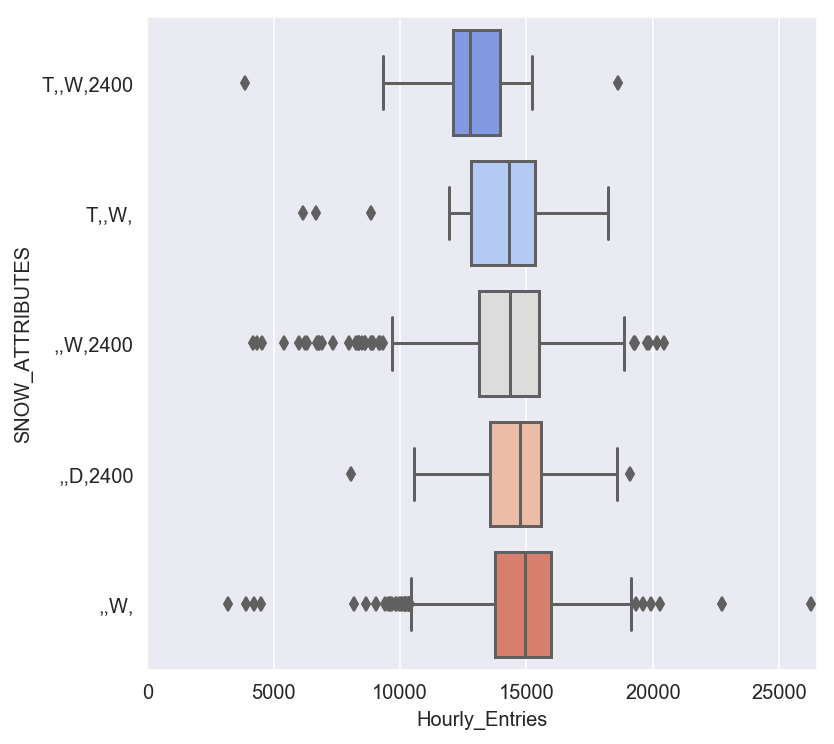

Column: TMAX ************************************
NAs: 0


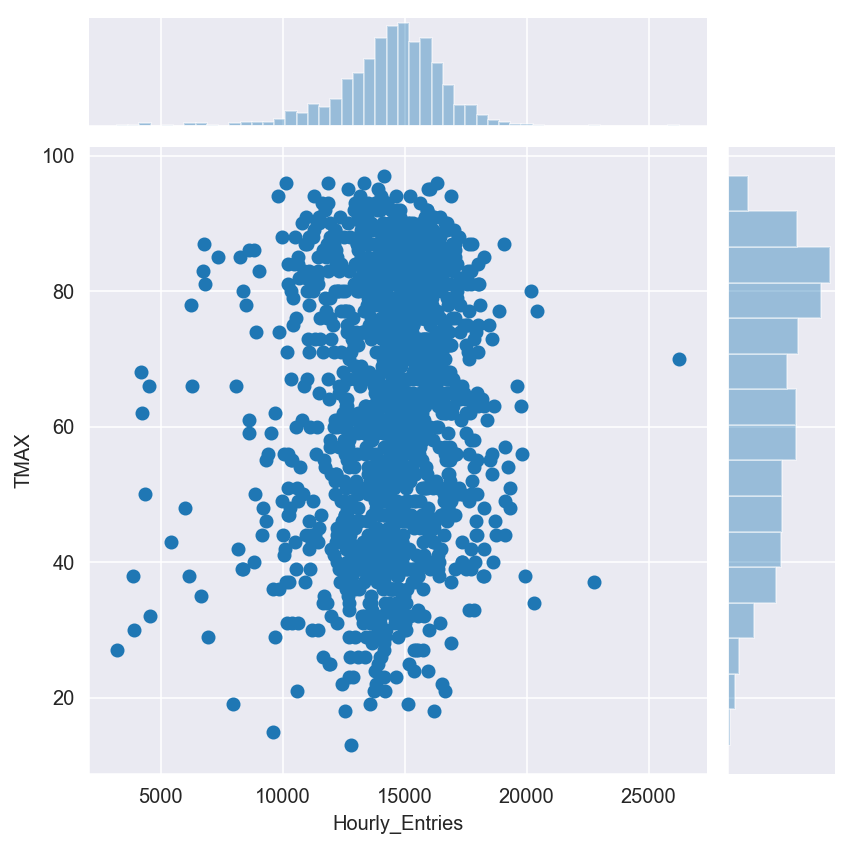

Column: TMIN ************************************
NAs: 0


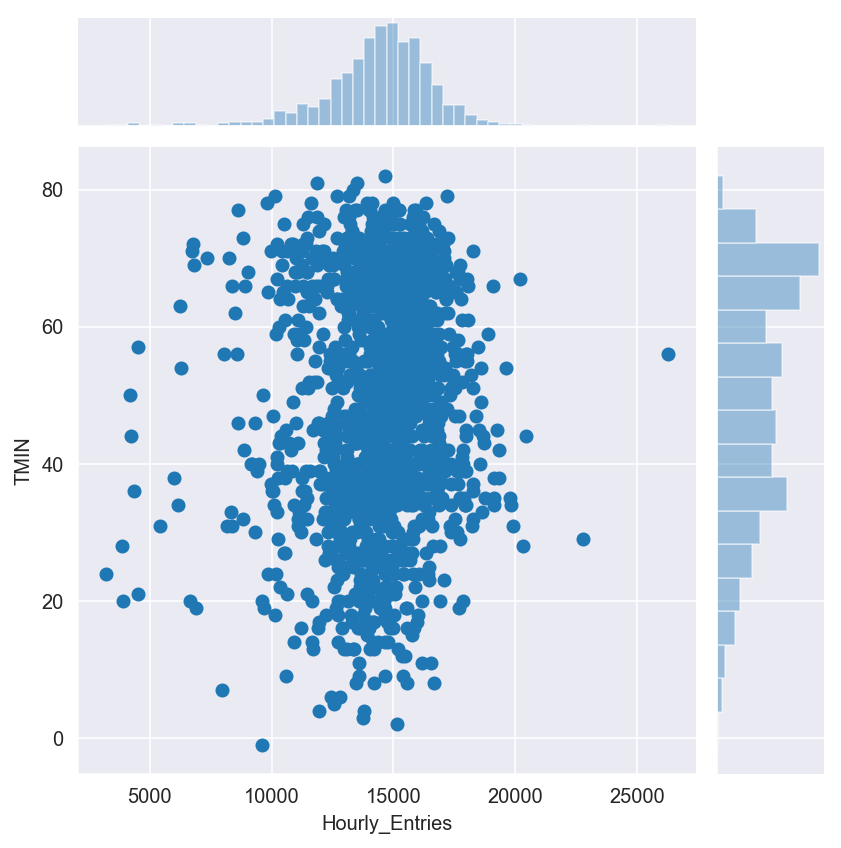

Column: has_PRCP ************************************


0    1039
1     536
Name: has_PRCP, dtype: int64

NAs: 0


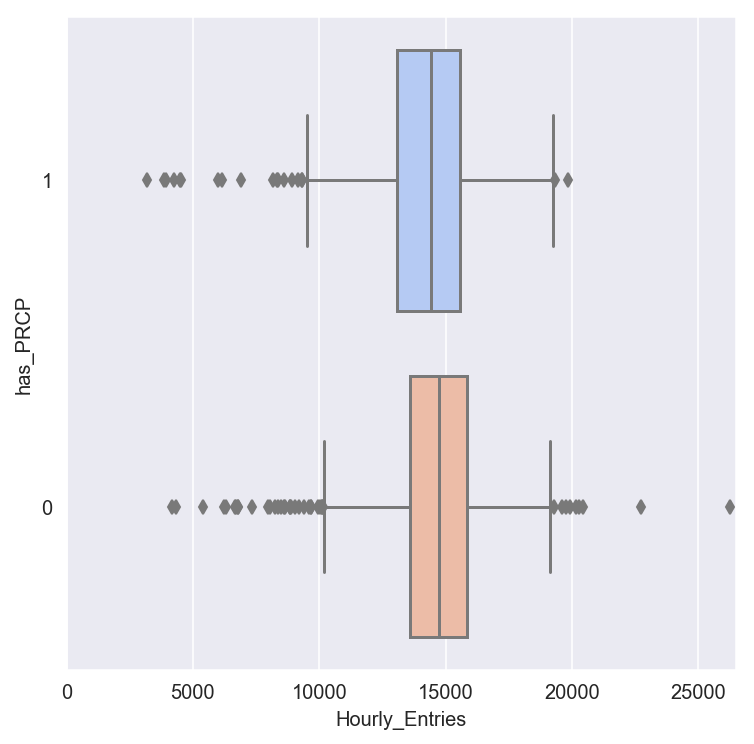

Column: has_SNOW ************************************


0    1520
1      55
Name: has_SNOW, dtype: int64

NAs: 0


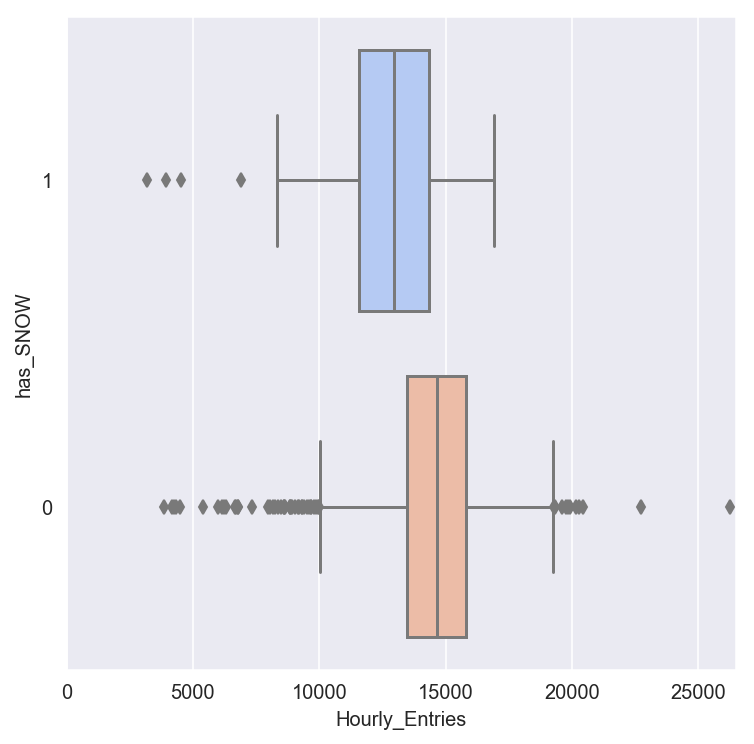

Column: has_heavy_PRCP ************************************


0    1547
1      28
Name: has_heavy_PRCP, dtype: int64

NAs: 0


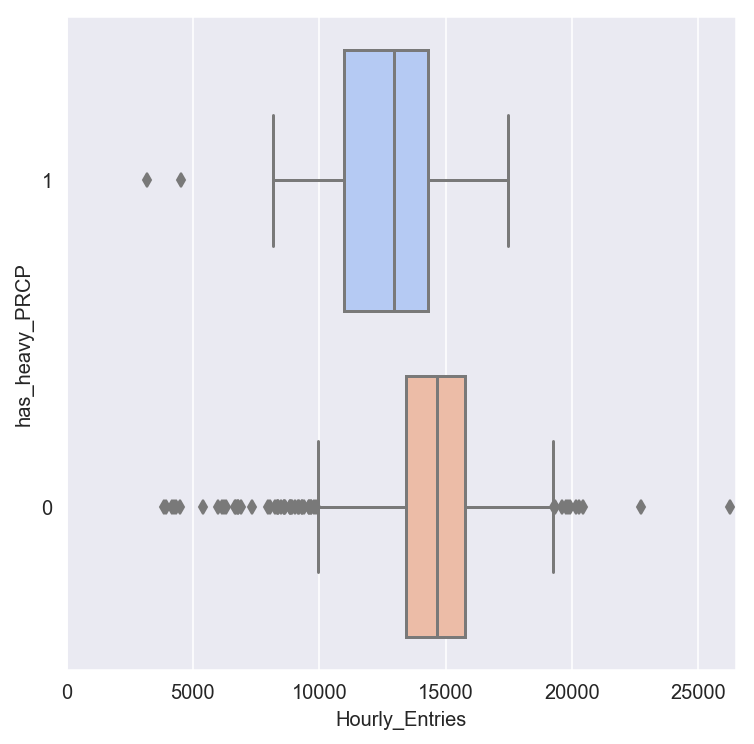

Column: has_heavy_SNOW ************************************


0    1560
1      15
Name: has_heavy_SNOW, dtype: int64

NAs: 0


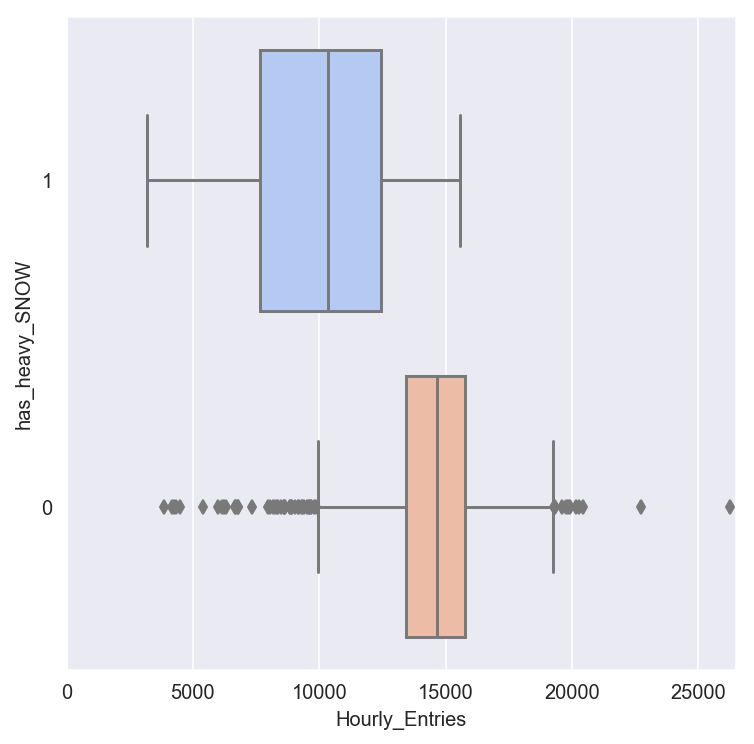

In [97]:
cols = lag_mask.columns.tolist()
target = 'Hourly_Entries'
dataframe_name = lag_mask

for col in cols:
    vals = dataframe_name[col].value_counts()
    print('Column:',col,'************************************')
    if len(vals) < 30:
        cats = list(dataframe_name[col].unique())
        means_to_cats = {dataframe_name[dataframe_name[col] == i][target].mean():i for i in cats}
        lofm = list(means_to_cats.keys())
        lofm.sort()
        
        display(vals)
        print('NAs:', dataframe_name[col].isna().sum())
        plt.figure(figsize=(6,6))
        plt.xlim(0,26500)
        sns.boxplot(target, col,palette='coolwarm', data = dataframe_name, orient='h', order=[means_to_cats[i] for i in lofm])
        plt.show();
    else:
        print('NAs:', dataframe_name[col].isna().sum())
        sns.jointplot(target,col,data=dataframe_name)
        plt.show();